In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.graphics as smg
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import math
import numpy as np
import warnings

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)


## Load Data

### Migration influx

In [2]:
with open("../migration_rates/countries.json") as buf:
    countries = list(json.load(buf).keys())

df_all = pd.read_csv(
    "../migration_rates/migration_rate_processed.csv", index_col=0, parse_dates=["date"]
)
df_all.set_index("date", inplace=True)
df_all["value"] = pd.to_numeric(df_all["value"], errors="coerce")

for c in countries:
    df_all.loc[df_all["country"] == c, "value"].fillna(
        df_all.loc[df_all["country"] == c].mean(), inplace=True
    )  # fill missing data with mean

series = {c: df_all[df_all.country == c].value for c in countries}
series["NL"]


date
2010-01-01     763.0
2010-02-01     649.0
2010-03-01     768.0
2010-04-01     772.0
2010-05-01     685.0
               ...  
2019-08-01    1076.0
2019-09-01    1130.0
2019-10-01     994.0
2019-11-01     815.0
2019-12-01     728.0
Name: value, Length: 120, dtype: float64

### Google trends

In [3]:
DATA_VERSION = "21-04-22"

LANGUAGE_ASSIGNMENT_FILE = "../keywords/assignment_language_country.json"


def get_input_file(country: str) -> str:
    directory = f"../processed_data/{DATA_VERSION}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    return os.path.join(directory, f"processed_{country}.csv")


with open(LANGUAGE_ASSIGNMENT_FILE) as f:
    assignment_language_country = json.load(f)

dataframes = {
    c: pd.read_csv(get_input_file(c), header=[0, 1], index_col=0, parse_dates=[0])
    for c in countries
}

keyword_ids = dataframes[countries[0]]["mean"].columns.to_list()
dataframes["NL"].head()


mean                                                                                                                                                                                                                                                                                                                                                                              sem                                                                                                                                                                                                                                                                                                                                                            
keyword_id    2       10      11      12      14      15      16      17      18      19      20      21     22     24      26    28    32     33      37      38    39   41     42      43      44      48      49      51      52      54      55      56      57      58      59      60     112     113     114     115     117     118     119     121     122     123     124     125     2       10      11      12     14      15      16      17      18     19     20     21      22     24      26    28    32      33      37      38    39   41     42      43      44      48      49      51     52      54     55      56      57      58      59     60    112    113    114    115    117    118    119    121    122    123    124    125  
date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
2007-01-01  12.143   7.143  20.714   0.000  19.429  66.143   0.000   0.000  34.143  28.143  56.143  27.286   0.0  28.286  47.143  0.0   0.0   0.000  29.714  21.286  0.0  0.0  33.571  49.000  31.143   0.000  60.429   0.000  37.286   0.000  44.143  23.000  19.857   0.000  27.286   7.286  78.000  36.857  61.286  83.286  56.714  43.429  87.571  71.143  52.429  57.143  60.000  25.571  5.742   7.143   9.788   0.000  6.941  12.023   0.000   0.000  17.141  5.462  5.990  9.020   0.000  8.909  10.173  0.0  0.000   0.000   8.742  13.751  0.0  0.0   7.979  12.490   8.166   0.000   6.750   0.000  6.050   0.000  0.459  10.994  11.319   0.000  13.083  4.704  2.573  3.262  0.747  4.839  4.922  1.270  1.131  1.243  2.918  1.056  0.926  0.481
2007-02-01   0.000   0.000  56.857   0.000   0.000  54.429  23.857  36.000   0.000  32.000  22.429  30.429   0.0  42.571   7.429  0.0  12.0   0.000   0.000  33.000  0.0  0.0   8.714  57.000  55.571   7.286  54.857  16.857  27.000   0.000  42.429  31.286  37.571   0.000   0.000   0.000  69.429  30.857  63.714  40.714  60.571  45.429  84.143  68.429  47.857  57.857  57.571  21.429  0.000   0.000  12.314   0.000  0.000  14.777  11.897  13.454   0.000  5.876  7.221  7.207   0.000  9.668   4.815  0.0  7.758   0.000   0.000  15.677  0.0  0.0   5.651   9.477  13.210   7.286  11.241  11.098  5.477   0.000  0.369  11.353   8.737   0.000   0.000  0.000  4.174  4.585  0.918  2.542  1.784  2.308  0.962  1.360  3.508  1.317  1.192  0.612
2007-03-01   0.000  72.000   0.000  44.571  13.143  42.143   0.000  36.429   0.000  37.286  16.714  69.143   0.0  23.286  30.429  0.0   0.0  40.286  51.143   0.000  0.0  0.0  28.429   9.571   0.000  38.714  24.000   0.000  17.286  28.714  40.429  14.714   7.286   0.000  51.571  19.857  61.571  33.714  57.429  63.429  55.000  40.857  84.

### Macroeconomics

In [4]:
def read_gdp(filename, country_names, skiprows=10, nrows=38):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows)

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df[df["GEO/TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("GEO/TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "gdp", "GEO/TIME": "country"})
    )
    df.index = pd.to_datetime(df.index)
    return df


def read_unempl(filename, country_names, skiprows=10, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Sheet 1")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "unempl", "TIME": "country"})
        .replace({":": np.nan})
    )

    df.index = pd.to_datetime(df.index)
    return df


def read_share_young_pop(filename, country_names, skiprows=9, nrows=29):
    df = pd.read_excel(filename, skiprows=skiprows, nrows=nrows, sheet_name="Share Young Pop")

    country_names_inv = {v: k for k, v in country_names.items()}

    df = (
        df.drop(columns=df.filter(like="Unnamed"), index=0)
        .loc[df["TIME"].isin(country_names.values())]
        .replace(country_names_inv)
        .set_index("TIME")
        .transpose()
        .stack()
        .reset_index(level=[1])
        .rename(columns={0: "share_young_pop", "TIME": "country"})
    )

    df.index = pd.to_datetime(df.index)
    return df


with open("../macroeconomics/country_names.json") as f:
    country_names = json.load(f)

df_gdp = read_gdp("../macroeconomics/GDP_pc_quart.xls", country_names)
df_unempl = read_unempl("../macroeconomics/Unemployment_Rate_Quart.xlsx", country_names)
df_share_young_pop = read_share_young_pop("../macroeconomics/Share_Young_Population.xlsx", country_names)
df_share_young_pop
# df_unempl


country  share_young_pop
2004-01-01    BE         0.184     
2004-01-01    BG         0.210     
2004-01-01    CZ         0.226     
2004-01-01    DK         0.176     
2004-01-01    EE         0.218     
...            ...              ...
2019-01-01    LU         0.191     
2019-01-01    HU         0.172     
2019-01-01    NL         0.188     
2019-01-01    AT         0.178     
2019-01-01    PL         0.171     

[304 rows x 2 columns]

## Resample, transform and merge

In [15]:
dfs_3m = {k: df.resample("3M").mean().fillna(0.0) for k, df in dataframes.items()}
sers_3m = {k: df.resample("3M").mean().fillna(0.0) for k, df in series.items()}

dfs_trans = dfs_3m
sers_trans = sers_3m

tmp_dfs = []

for c in countries:
    tmp_dep = (
        sers_trans[c]
        .to_frame()
        .assign(country=c)
        .assign(month=sers_trans[c].index.month.astype(str))
    )
    ar_1 = sers_trans[c].shift(1).rename("ar_1")
    ar_2 = sers_trans[c].shift(2).rename("ar_2")
    ar_3 = sers_trans[c].shift(3).rename("ar_3")
    ar_4 = sers_trans[c].shift(4).rename("ar_4")
    tmp_ind_1 = dfs_trans[c]["mean"].shift(1).rename(columns=lambda x: x + "_1")
    tmp_ind_2 = dfs_trans[c]["mean"].shift(2).rename(columns=lambda x: x + "_2")
    tmp_ind_3 = dfs_trans[c]["mean"].shift(3).rename(columns=lambda x: x + "_3")
    tmp_ind_4 = dfs_trans[c]["mean"].shift(4).rename(columns=lambda x: x + "_4")
    tmp_df = pd.concat(
        [tmp_dep, tmp_ind_1, tmp_ind_2, tmp_ind_3, tmp_ind_4, ar_1, ar_2, ar_3, ar_4],
        axis=1,
    )["2010-12-31":"2019-12-31"]
    tmp_dfs.append(tmp_df)

df_panel_1y = pd.concat(tmp_dfs).sort_index()

# for df in [df_share_young_pop, df_gdp, df_unempl]:
#     df_tmp = (
#         df.groupby([pd.Grouper(freq="1M"), "country"]).mean().shift(12).pct_change()
#     )
#     df_panel_1y = df_panel_1y.join(
#         df_tmp, on=[df_panel_1y.index, df_panel_1y["country"]], how="left"
#     )

df_panel_1y


value   country month    2_1    10_1    11_1    12_1    14_1    15_1    16_1    17_1   18_1    19_1    20_1    21_1    22_1    24_1    26_1    28_1    32_1    33_1    37_1    38_1    39_1    41_1    42_1    43_1    44_1    48_1    49_1    51_1    52_1    54_1    55_1    56_1    57_1    58_1    59_1    60_1    112_1   113_1   114_1   115_1   117_1   118_1   119_1   121_1   122_1   123_1   124_1   125_1    2_2    10_2    11_2    12_2    14_2    15_2    16_2    17_2    18_2    19_2    20_2    21_2    22_2    24_2    26_2    28_2    32_2    33_2    37_2    38_2    39_2    41_2    42_2    43_2    44_2    48_2    49_2    51_2    52_2    54_2    55_2    56_2    57_2    58_2    59_2    60_2    112_2   113_2   114_2   115_2   117_2   118_2   119_2   121_2   122_2   123_2   124_2   125_2    2_3    10_3    11_3    12_3    14_3    15_3    16_3    17_3   18_3    19_3    20_3    21_3    22_3    24_3    26_3    28_3    32_3    33_3    37_3    38_3    39_3    41_3    42_3    43_3   \
date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2011-01-31    842.333    FR      1   11.524  32.810  12.762   9.286  21.048  26.857  20.190   8.381  0.000  39.429   4.095  33.524  34.905  22.190  24.667   0.000  11.048  21.857  34.048   5.429   0.000  12.952  29.667  19.238  36.476  22.143  25.905  14.619  12.286  13.238  16.429  15.000  31.810  30.143  19.429  19.190  35.810  33.810  61.381  10.619  42.762  66.286  76.286  16.429  63.095  48.000  41.571  25.857  25.286   7.905  14.048   0.000  42.048  19.667  17.095   7.762   0.000  30.952  10.238  30.905  17.429  25.905  14.762   0.000  21.190  26.143  22.905   8.381   0.000  19.857  30.905  28.714  26.762  33.143  32.905  28.762  13.810  30.762  24.476  13.619  26.190  29.143   7.524  23.095  36.095  32.810  65.762  10.095  37.286  67.048  65.619  33.381  52.476  49.857  40.381  22.333  18.810  14.381  18.952   8.000  32.286  31.810  28.714  22.762  0.000  35.619   8.905  18.381  39.905  27.333  27.857   0.000  14.286  28.381  39.095  17.333   0.000  27.000  29.667  33.857   
2011-01-31     98.000    FI      1    0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000  0.000  25.905   0.000  14.857   2.952   6.524   3.571   0.000   0.000   0.000   9.810   0.000   0.000   0.000   0.000   1.619   0.000   0.000   0.000   0.000   0.000   0.000  43.095   0.000   0.000   0.000   0.000   0.000  45.762  33.571  45.476  51.524  47.048  22.524  68.429  47.000  50.429  47.048  45.762  54.286   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000  17.952   0.000  29.714   0.000  19.143   8.190   0.000   0.000   0.000  27.762   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000  64.333   0.000   0.000   0.000   0.000   0.000  54.333  38.810  42.190  26.333  26.857  15.143  57.429  48.952  37.238  46.905  44.714  59.238   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000  0.000  13.381   0.000  10.619   0.000   9.429   8.952   0.000   0.000   0.000   9.667   0.000   0.000   0.000   0.000   0.000   
2011-01-31    159.000    L

## Evaluation functions and common variables

In [30]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import feature_selection
from sklearn import compose
from sklearn import impute
from sklearn import dummy
from sklearn import neural_network

t_min = "2011-01-01"
t_max = "2019-12-01"
t_split_lower = "2017-12-01"
t_split_upper = "2018-01-01"

scoring = ["neg_mean_absolute_percentage_error", "neg_root_mean_squared_error", "r2"]

# selected_countries = ["FR", "GB", "IT", "ES", "RO"]
selected_countries = countries


df_panel_1y = df_panel_1y[df_panel_1y.country.isin(selected_countries)]

dummies_country = pd.get_dummies(df_panel_1y["country"], drop_first=False)
dummy_cols = dummies_country.columns.tolist()

dummies_month = pd.get_dummies(df_panel_1y["month"], prefix="month", drop_first=False)
dummy_cols_month = dummies_month.columns.tolist()

df_tmp_combined = df_panel_1y["country"] + "_" + df_panel_1y["month"]
dummies_combined = pd.get_dummies(df_tmp_combined, drop_first=False)
dummy_cols_combined = dummies_combined.columns.tolist()

df_panel_1y = pd.concat(
    [df_panel_1y, dummies_country, dummies_month, dummies_combined], axis=1
)

x = df_panel_1y.drop(columns="value")[t_min:t_max]
y = df_panel_1y["value"][t_min:t_max]

x_train = x[t_min:t_split_lower]
y_train = y[t_min:t_split_lower]
x_test = x[t_split_upper:t_max]
y_test = y[t_split_upper:t_max]


def score_cv(reg, X, y):
    scores = model_selection.cross_validate(reg, X=X, y=y, scoring=scoring)
    return pd.DataFrame(scores)


def score_test(reg, X, y):
    scores = {s: metrics.get_scorer(s)(reg, X, y) for s in scoring}
    return pd.Series(scores)


def plot_panel(df, countries, n_rows=7, n_cols=4, figsize=(25, 25), autoscale=True):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    for c, ax in zip(countries, axs.flatten()):
        df_to_plot = df[df["country"] == c].drop(columns="country")
        if autoscale is not None:
            y_max = max([df_to_plot[col].max() for col in df_to_plot.columns])
            y_min = min([df_to_plot[col].min() for col in df_to_plot.columns])
        df_to_plot.plot(ax=ax, ylim=(y_min * 1.2, y_max * 1.2) if autoscale else None)
        ax.set_title(c)
    fig.tight_layout()
    return fig, axs


def plot_prediction(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    return plot_panel(df_pred, countries, **kwargs)


def plot_residuals(reg, X, countries=selected_countries, **kwargs):
    y_pred = reg.predict(X)
    df_pred = df_panel_1y[["value", "country"]][t_min:t_max].assign(pred=y_pred)
    df_pred["residuals"] = df_pred["pred"] - df_pred["value"]
    return plot_panel(df_pred[["residuals", "country"]], countries, **kwargs)



## Models

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.003      0.001                    -9.264                              -2889.933              -0.102 
1    0.001      0.001                    -5.879                              -3564.782              -0.002 
2    0.002      0.002                    -4.976                              -4130.083              -0.009 
3    0.001      0.001                    -5.354                              -4489.440              -0.011 
4    0.001      0.002                    -5.281                              -4124.431              -0.002

Mean CV score:


fit_time                                      0.002
score_time                                    0.002
test_neg_mean_absolute_percentage_error      -6.151
test_neg_root_mean_squared_error          -3839.734
test_r2                                      -0.025
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -4.795e+16
neg_root_mean_squared_error          -4.220e+03
r2                                   -9.605e-04
dtype: float64

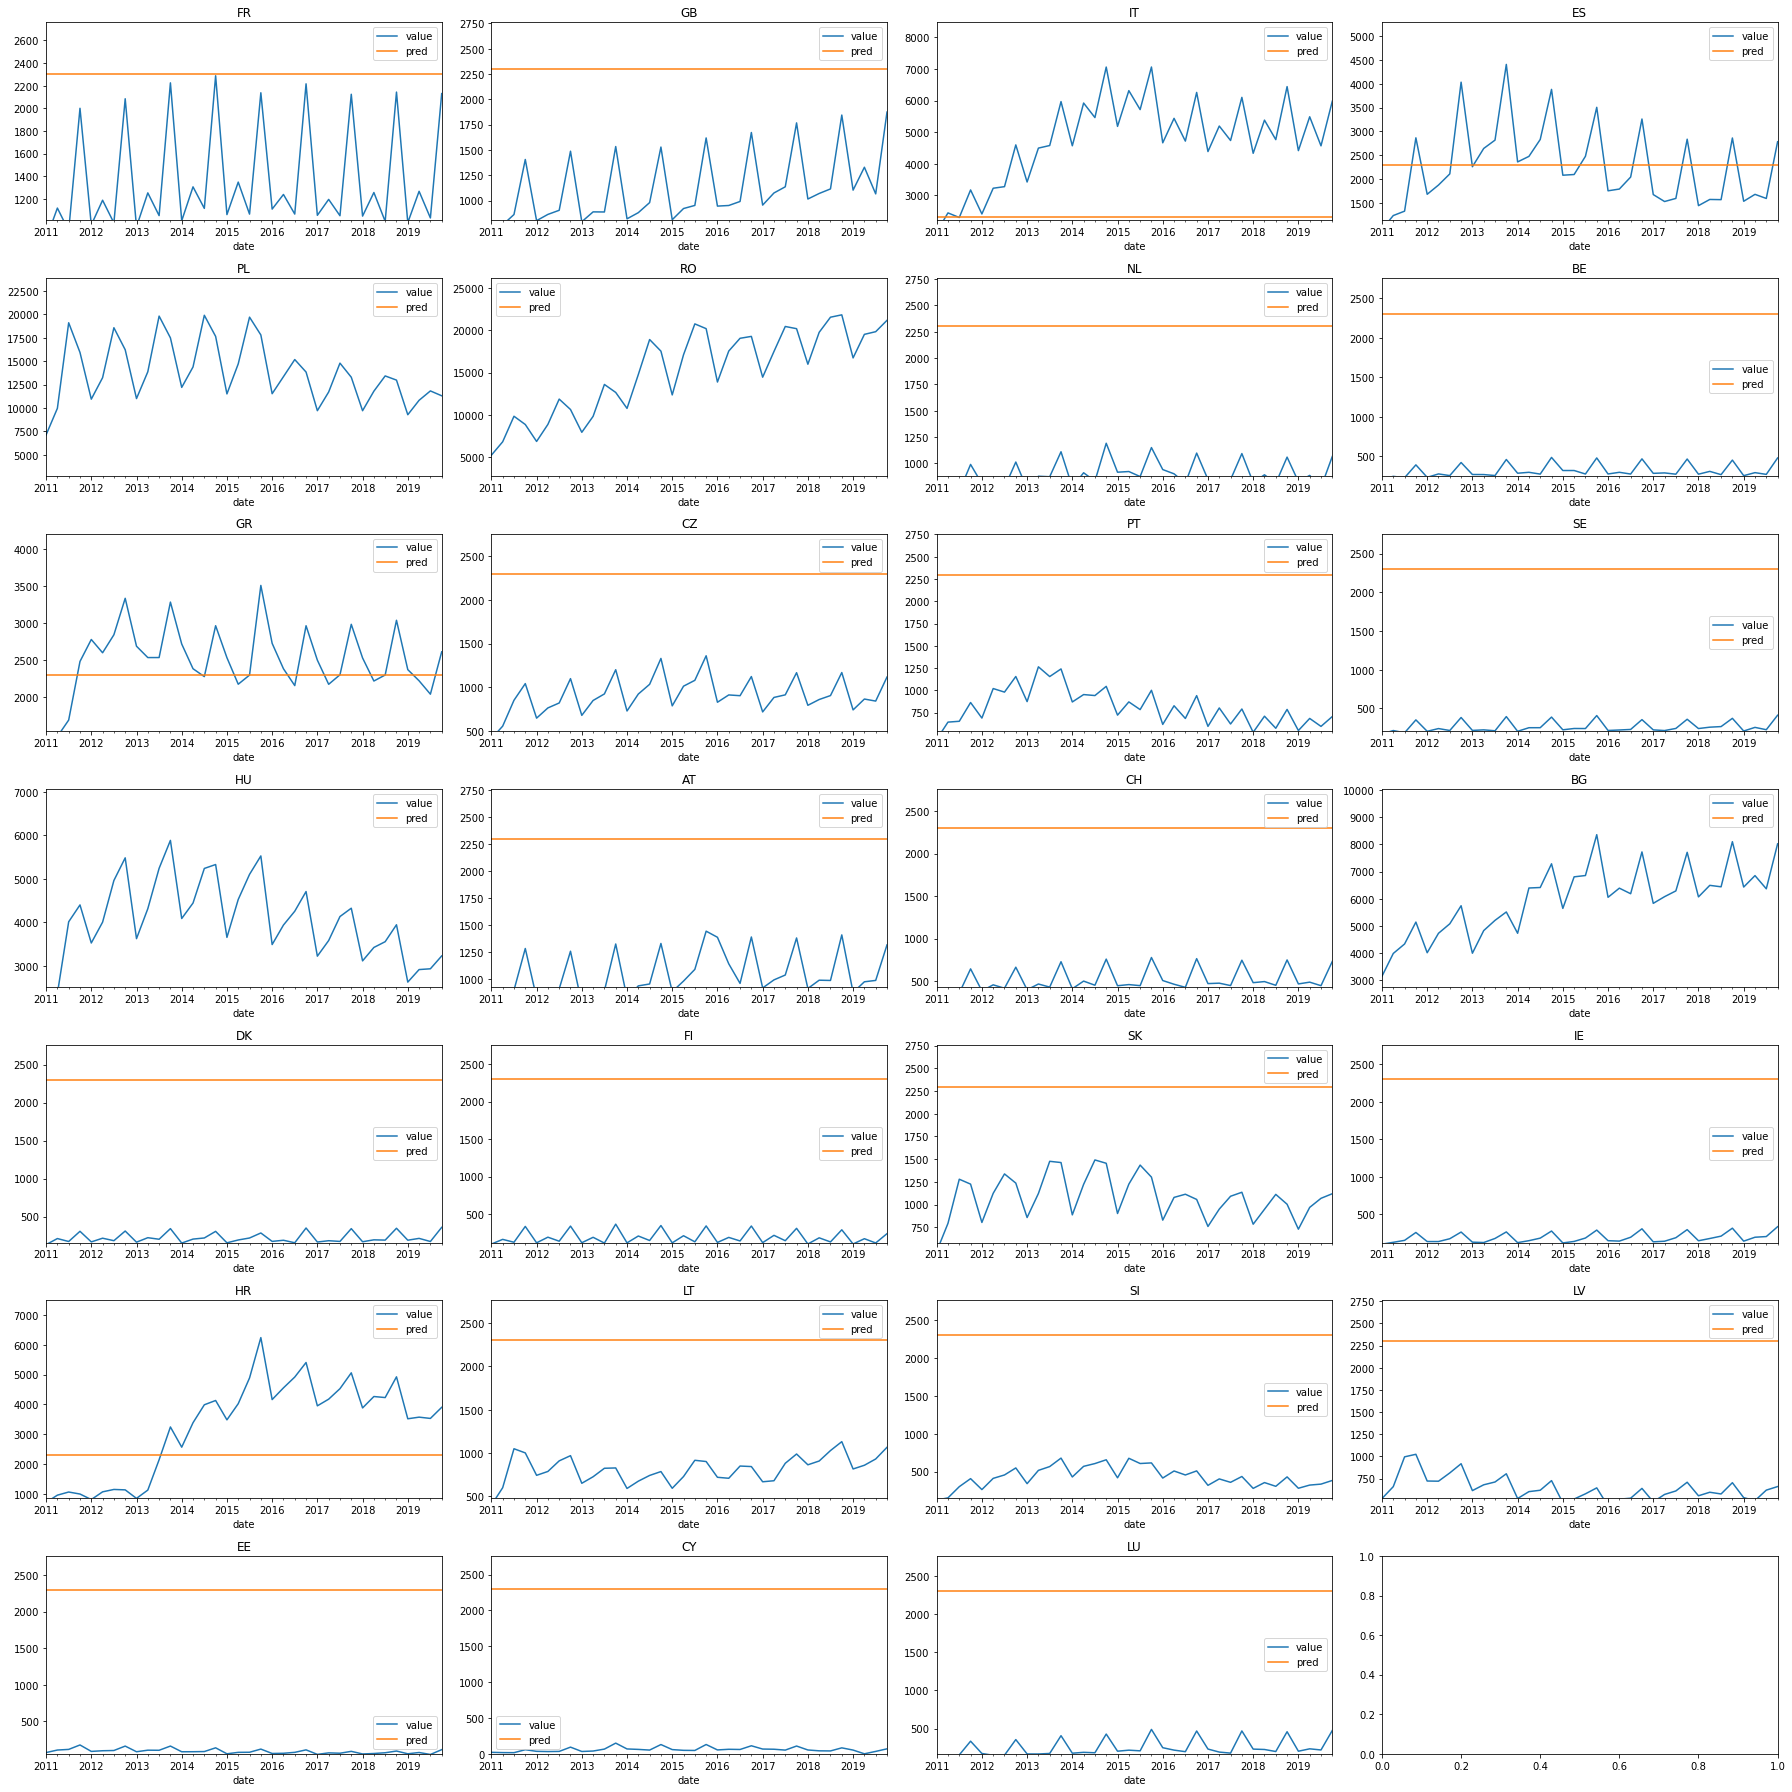

In [17]:
features = dummy_cols

reg = dummy.DummyRegressor(strategy="mean")

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])


### country dummies

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.005      0.008                    -0.654                              -2039.416               0.451 
1    0.004      0.004                    -0.309                              -1164.380               0.893 
2    0.010      0.003                    -0.254                              -1029.675               0.937 
3    0.004      0.005                    -0.378                              -1462.178               0.893 
4    0.003      0.002                    -0.232                              -1322.332               0.897

Mean CV score:


fit_time                                      0.005
score_time                                    0.004
test_neg_mean_absolute_percentage_error      -0.365
test_neg_root_mean_squared_error          -1403.596
test_r2                                       0.814
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.001e+15
neg_root_mean_squared_error          -1.438e+03
r2                                    8.838e-01
dtype: float64

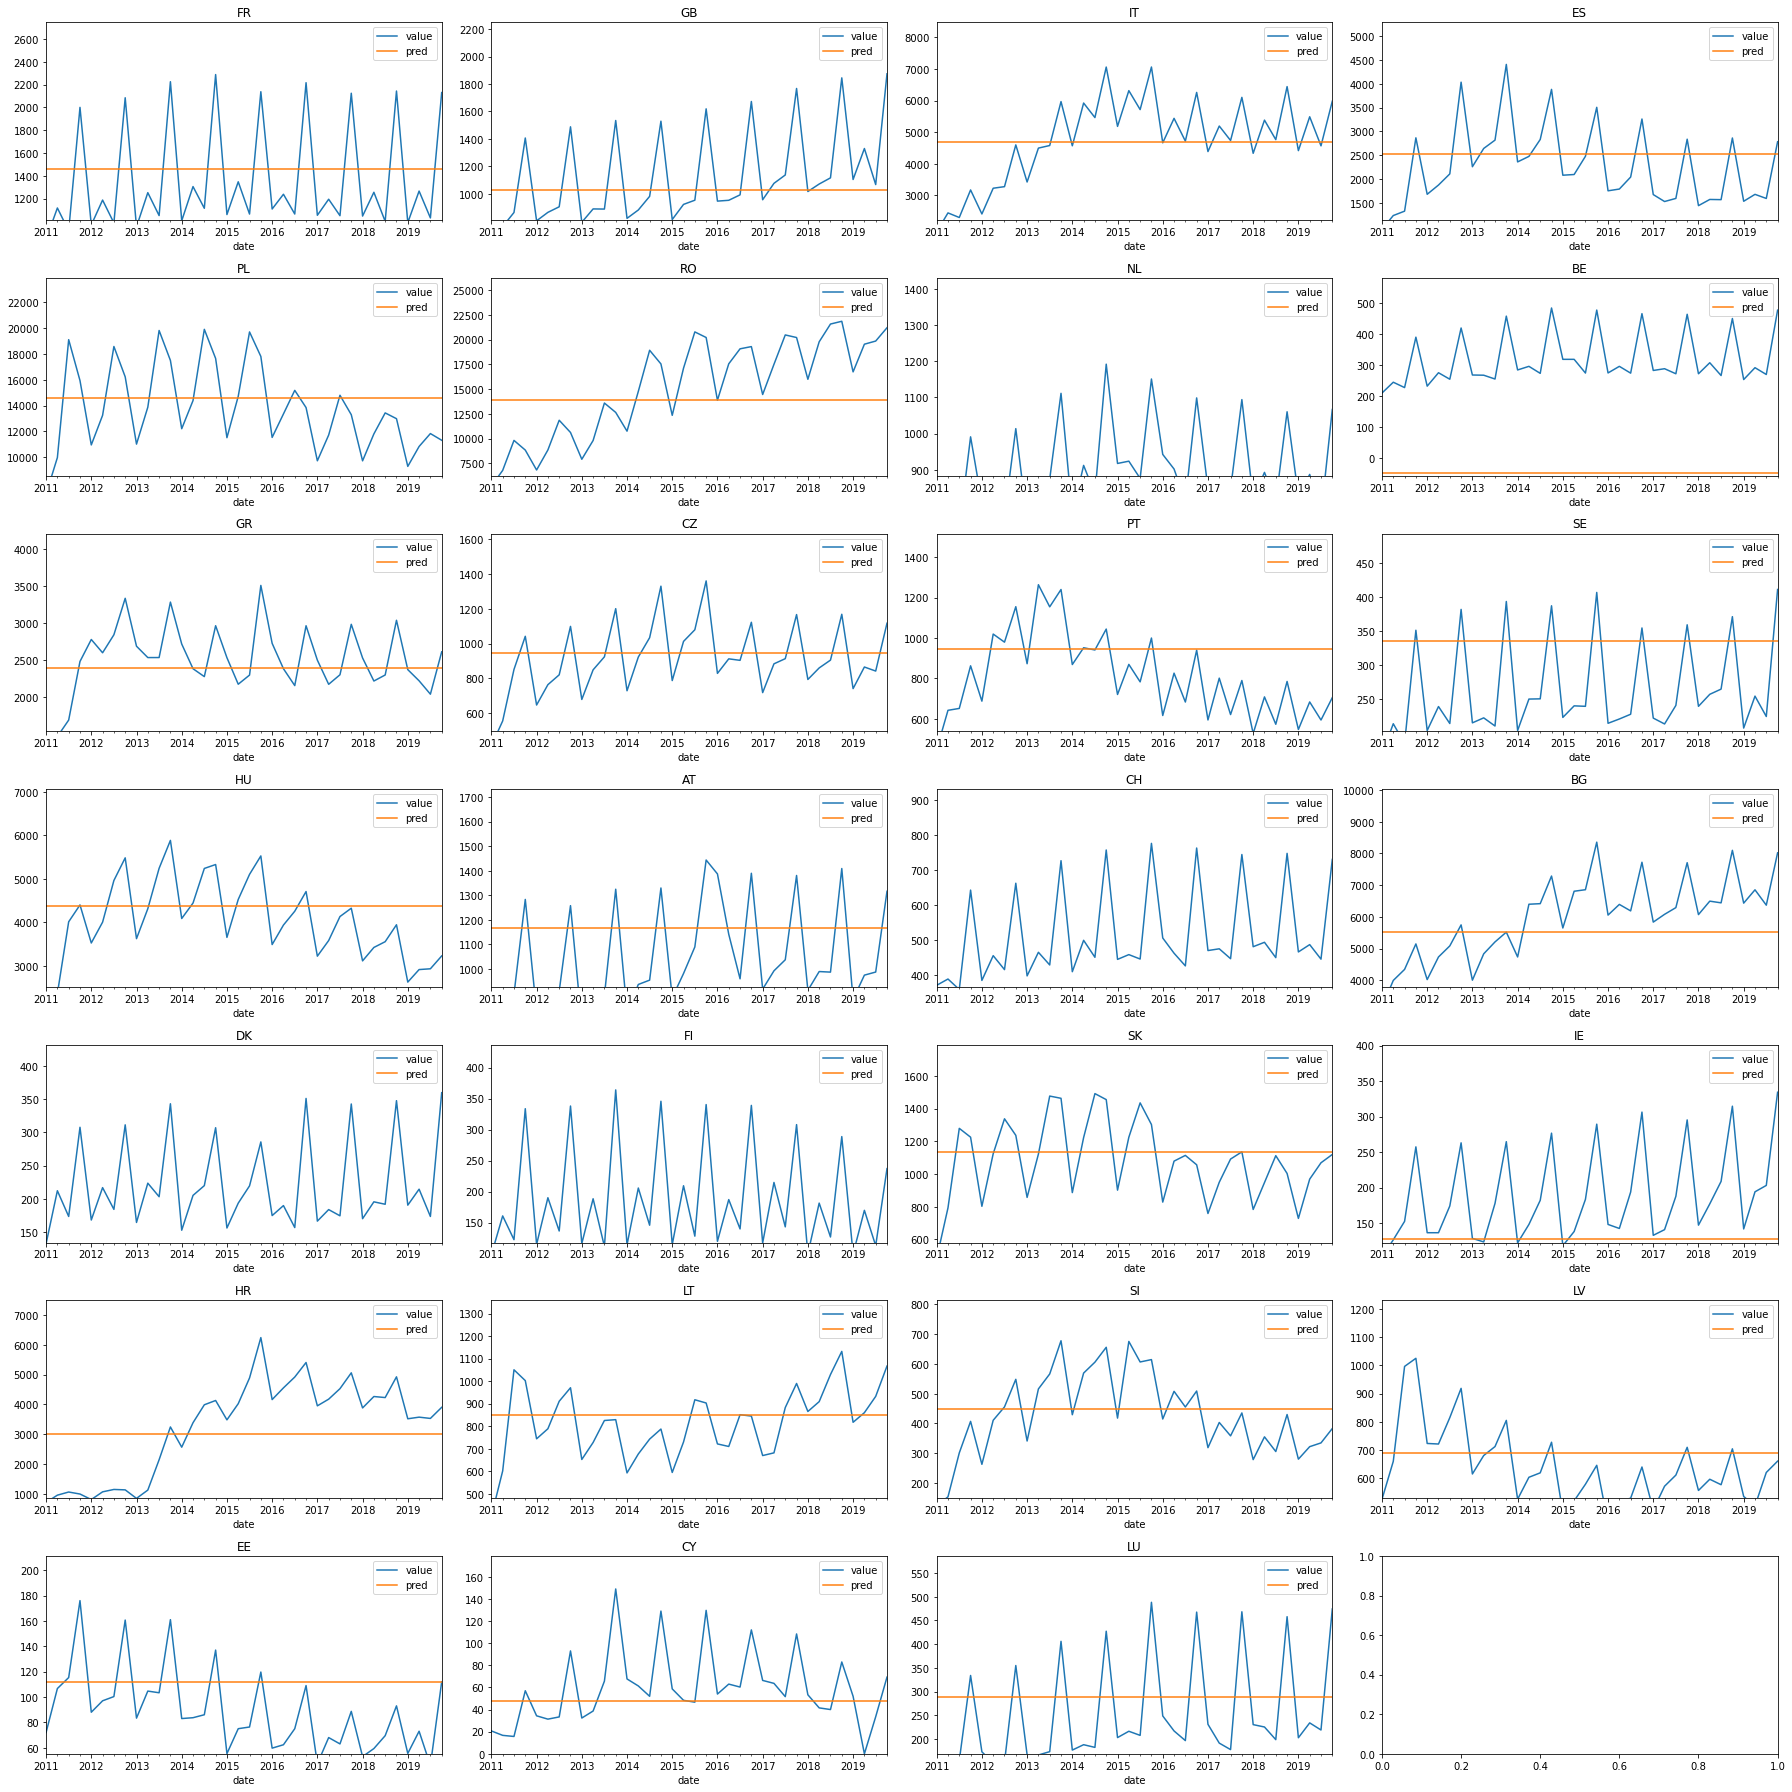

In [18]:
features = dummy_cols

reg = linear_model.LinearRegression()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



### ar(1)

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.006      0.004                    -0.379                              -1098.573               0.841 
1    0.004      0.003                    -0.277                              -1110.876               0.903 
2    0.004      0.006                    -0.370                              -1242.978               0.909 
3    0.004      0.003                    -0.281                              -1215.007               0.926 
4    0.004      0.005                    -0.278                               -882.307               0.954

Mean CV score:


fit_time                                      0.004
score_time                                    0.004
test_neg_mean_absolute_percentage_error      -0.317
test_neg_root_mean_squared_error          -1109.948
test_r2                                       0.906
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.071e+15
neg_root_mean_squared_error          -8.655e+02
r2                                    9.579e-01
dtype: float64

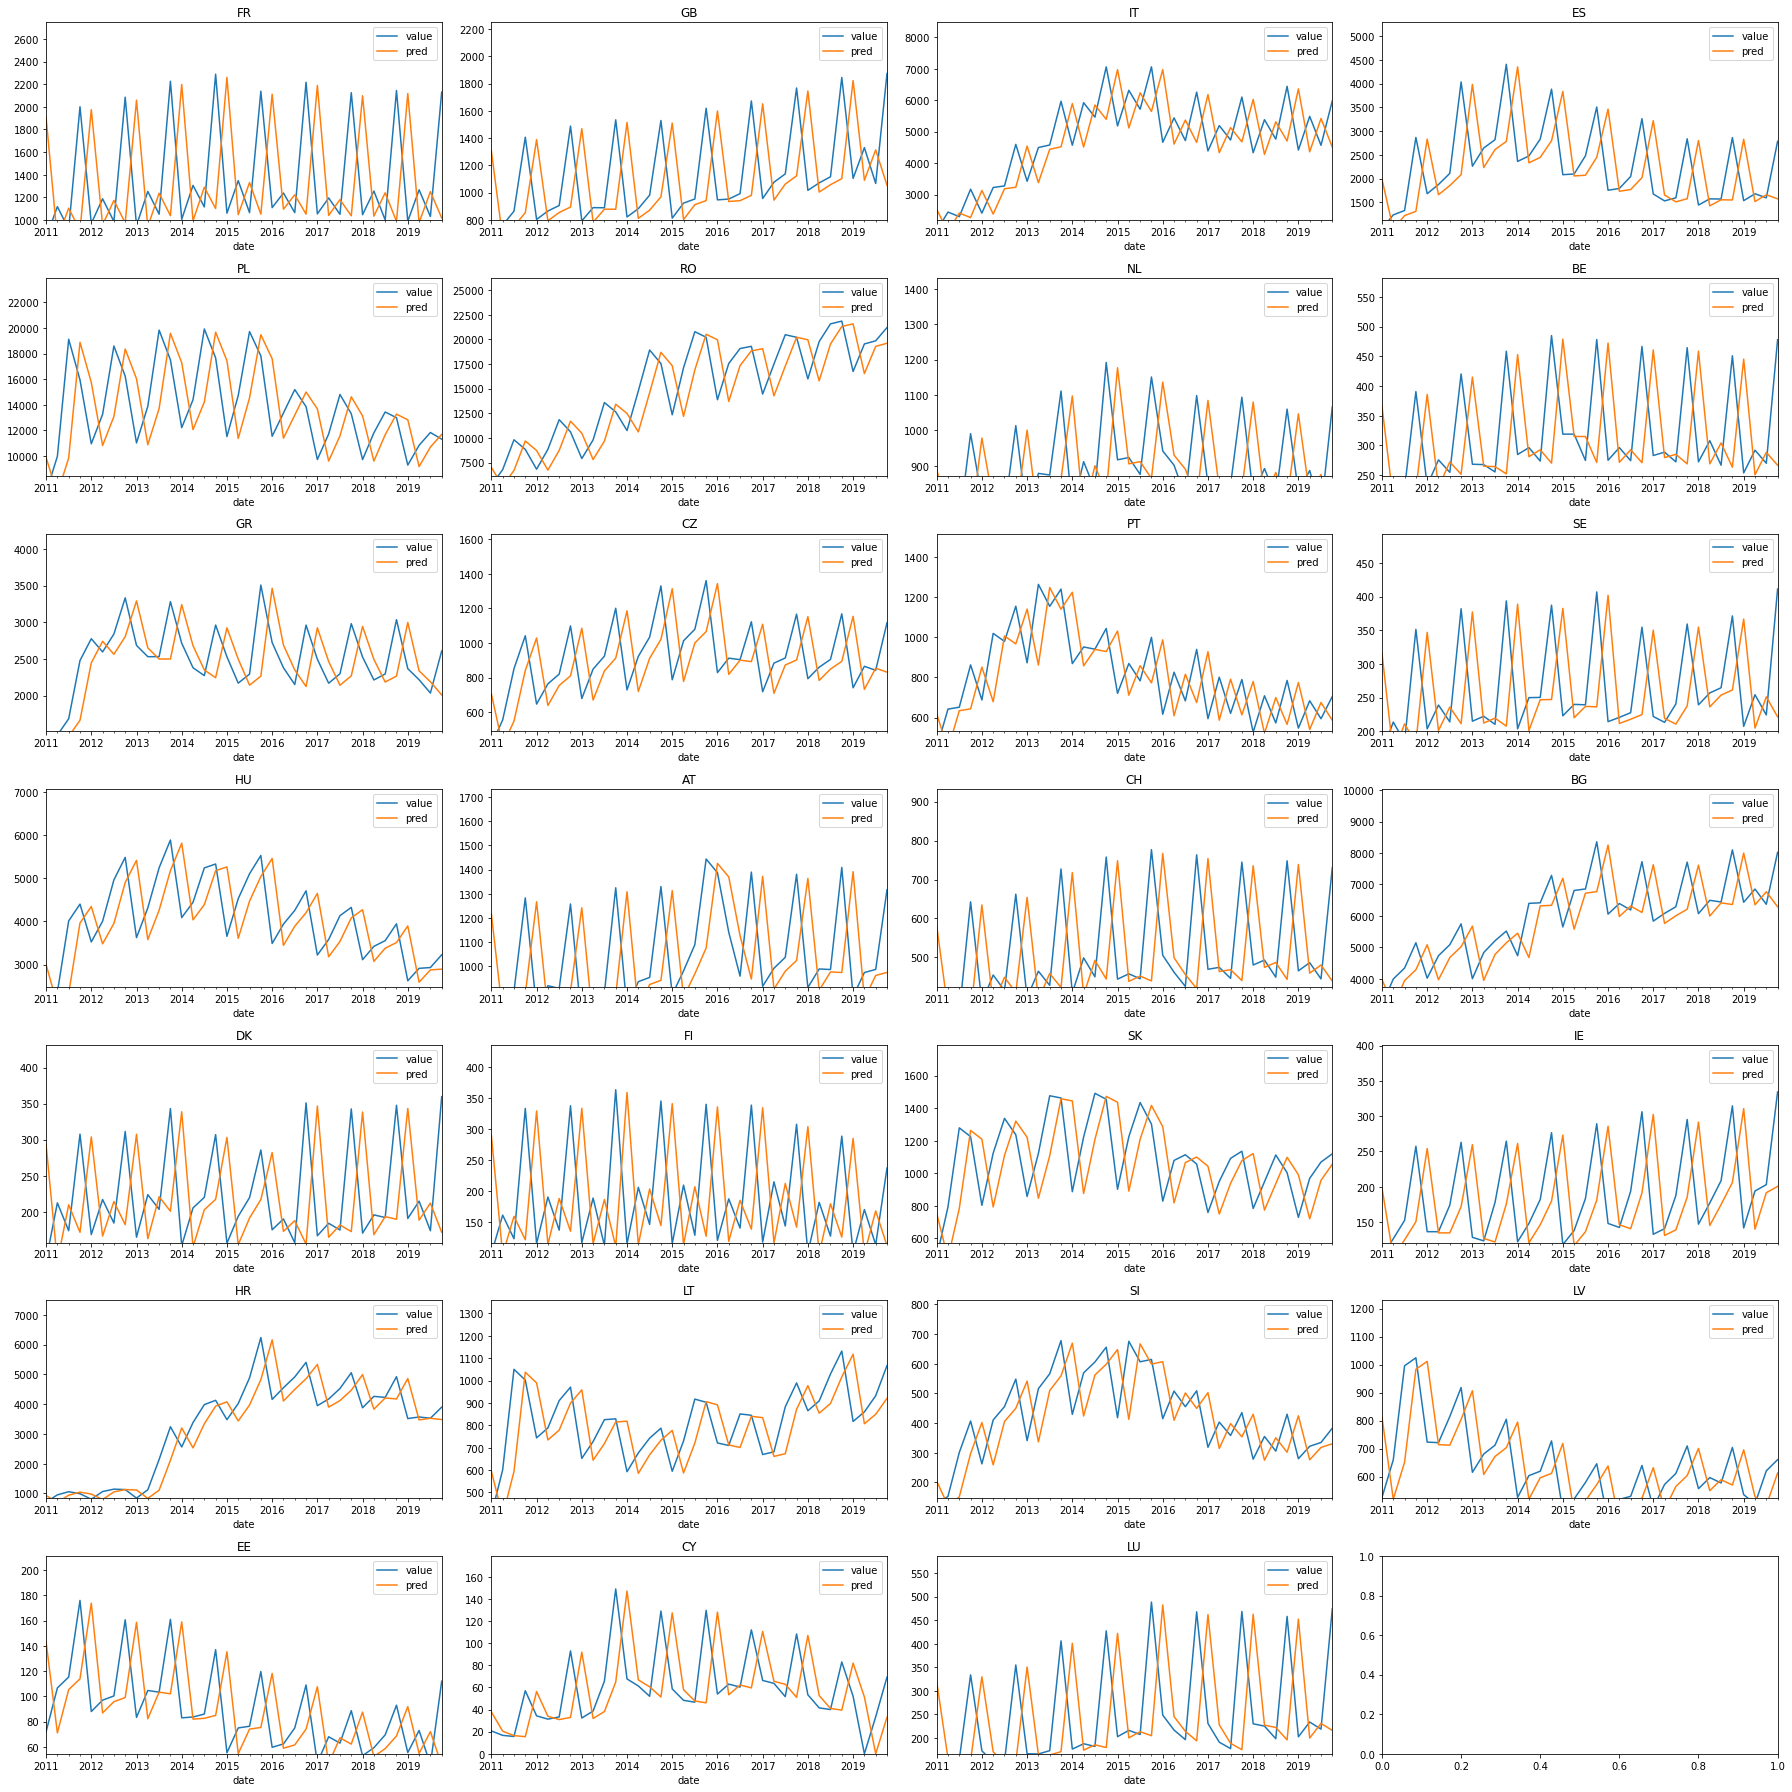

In [19]:
features = ["ar_1"]

reg = linear_model.LinearRegression(fit_intercept=False)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



### ar(4)

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.003      0.003                    -0.173                               -756.219               0.925 
1    0.003      0.004                    -0.136                               -503.823               0.980 
2    0.014      0.008                    -0.150                               -726.610               0.969 
3    0.005      0.004                    -0.135                               -525.985               0.986 
4    0.004      0.005                    -0.153                               -787.222               0.964

Mean CV score:


fit_time                                     0.006
score_time                                   0.005
test_neg_mean_absolute_percentage_error     -0.149
test_neg_root_mean_squared_error          -659.972
test_r2                                      0.965
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -9.650e+14
neg_root_mean_squared_error          -4.337e+02
r2                                    9.894e-01
dtype: float64

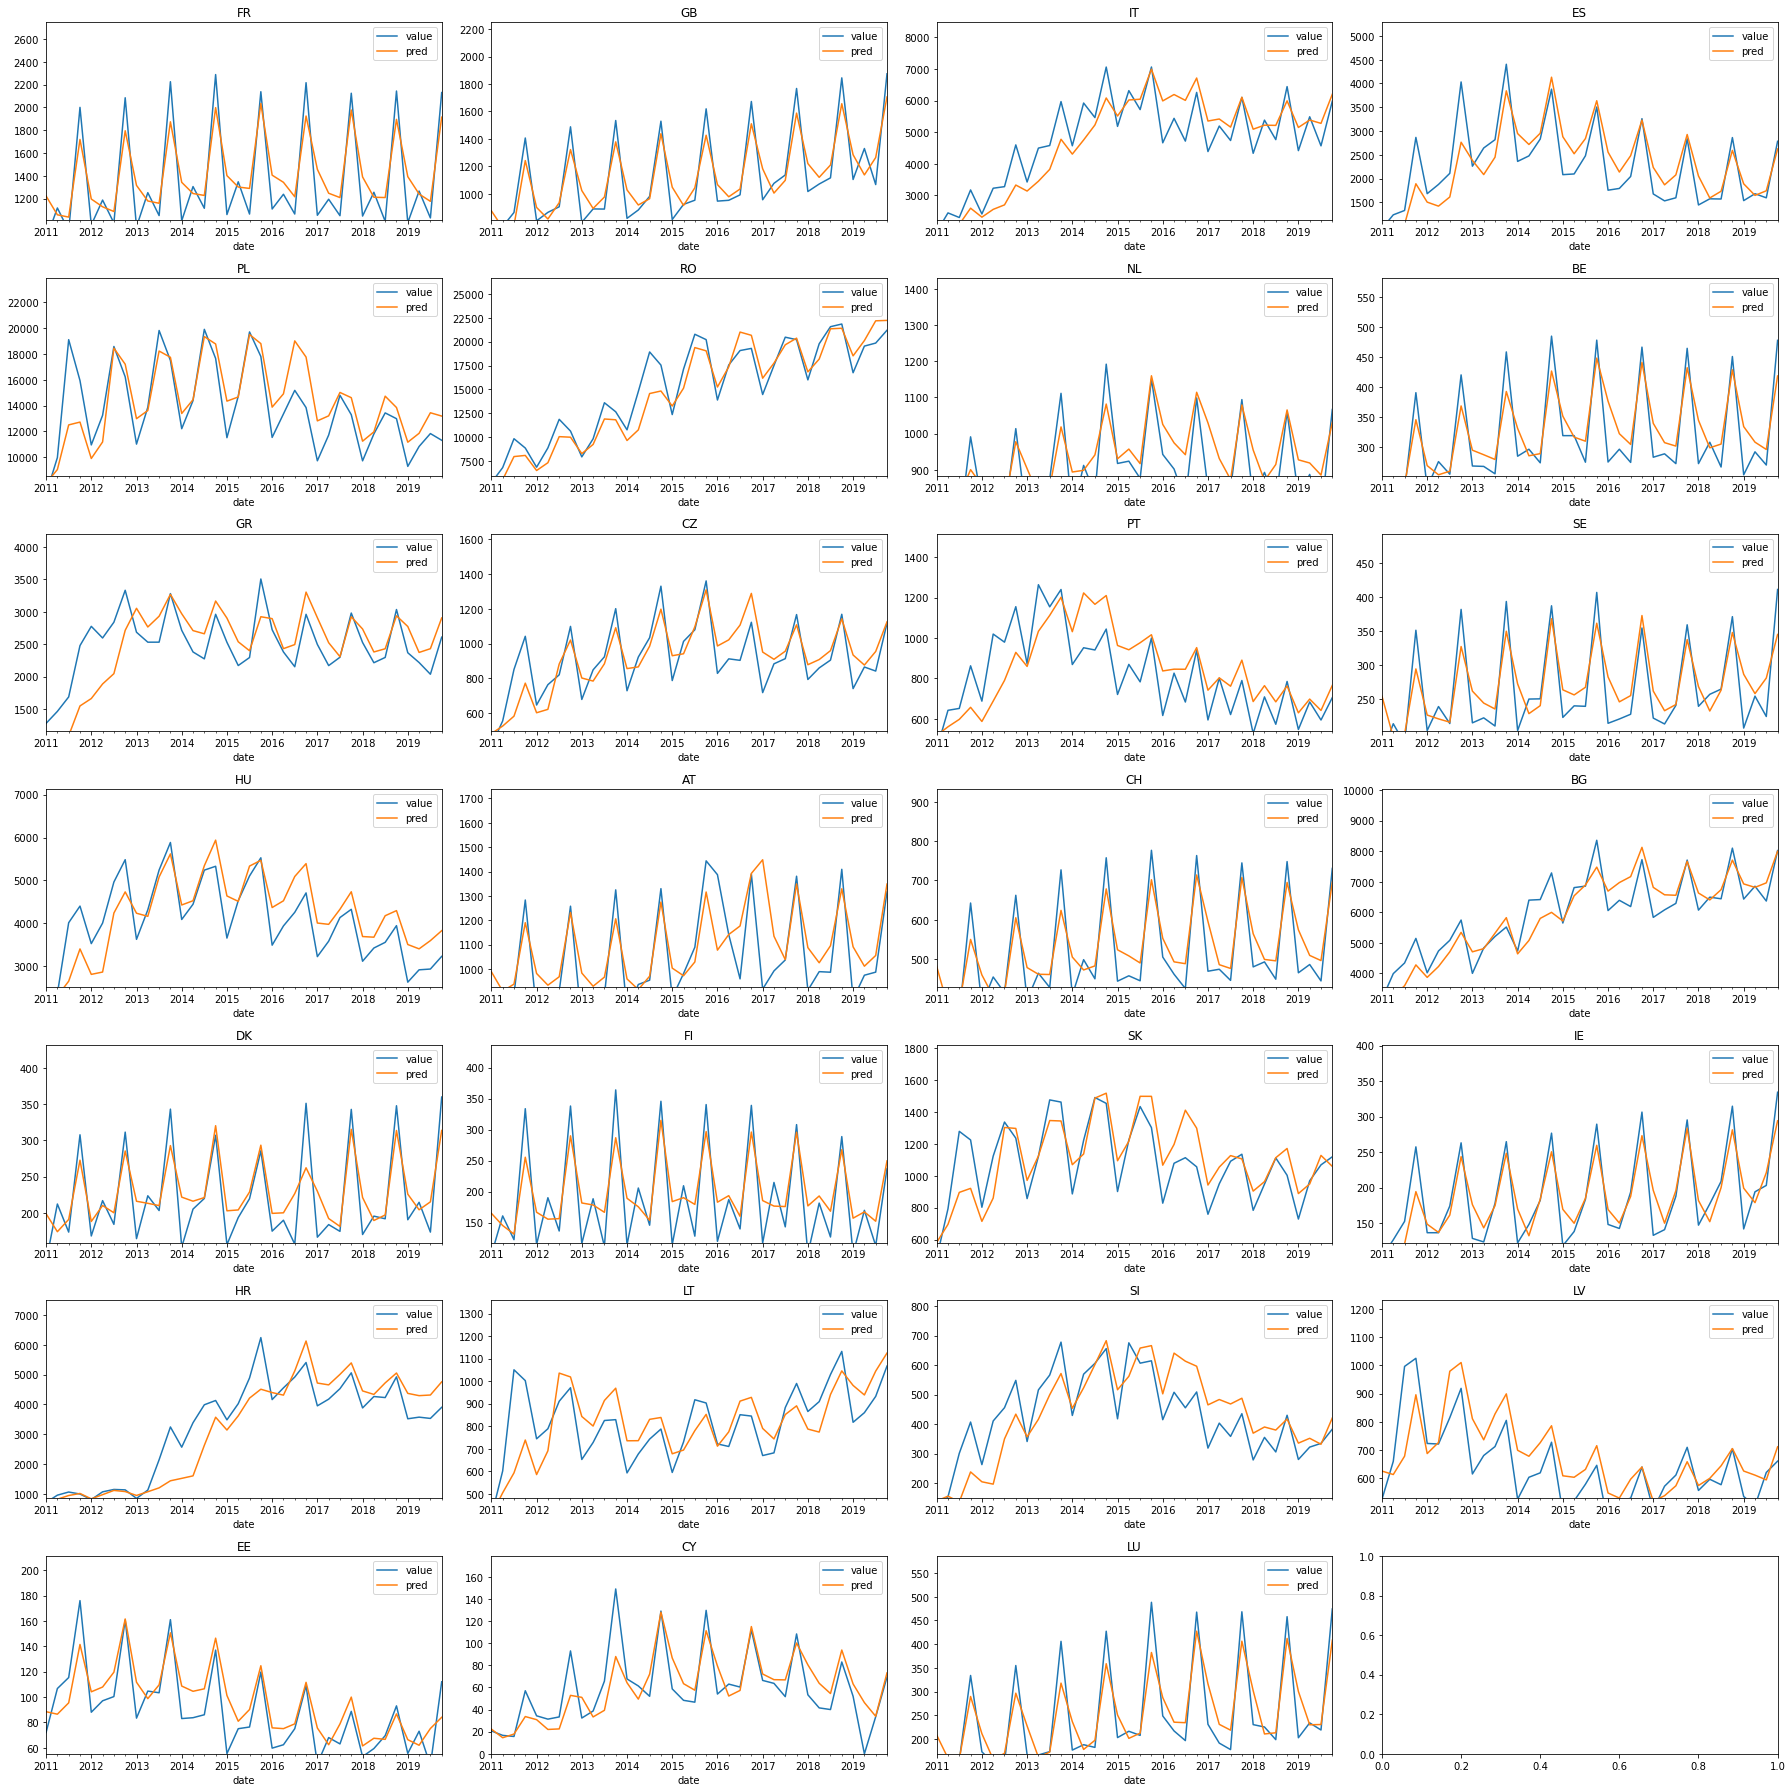

In [22]:
features = ["ar_1", "ar_2", "ar_3", "ar_4"]

reg = linear_model.LinearRegression(fit_intercept=False, positive=True)

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])



### kw 19

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.005      0.003                    -1.081                              -1868.575               0.539 
1    0.007      0.003                    -0.858                              -1111.986               0.903 
2    0.004      0.005                    -0.426                               -956.663               0.946 
3    0.003      0.003                    -0.528                              -1379.520               0.905 
4    0.003      0.007                    -0.612                              -1357.161               0.892

Mean CV score:


fit_time                                      0.005
score_time                                    0.004
test_neg_mean_absolute_percentage_error      -0.701
test_neg_root_mean_squared_error          -1334.781
test_r2                                       0.837
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.746e+15
neg_root_mean_squared_error          -1.493e+03
r2                                    8.746e-01
dtype: float64

AT      -1419.073
BE      -1424.029
BG       3123.326
CH      -1980.535
CY       -542.117
CZ      -1085.528
DK      -1601.555
EE         94.905
ES       1539.604
FI      -1162.147
FR       -877.434
GB      -1499.877
GR        533.645
HR       1264.769
HU       2289.159
IE      -1315.470
IT       2504.276
LT       -448.568
LU       -711.503
LV       -496.936
NL      -1720.464
PL      11660.926
PT        380.120
RO      11467.309
SE      -1344.012
SI       -686.376
SK       -896.799
19_1       21.030
19_2        7.907
19_3       -8.389
19_4       27.666
dtype: float64

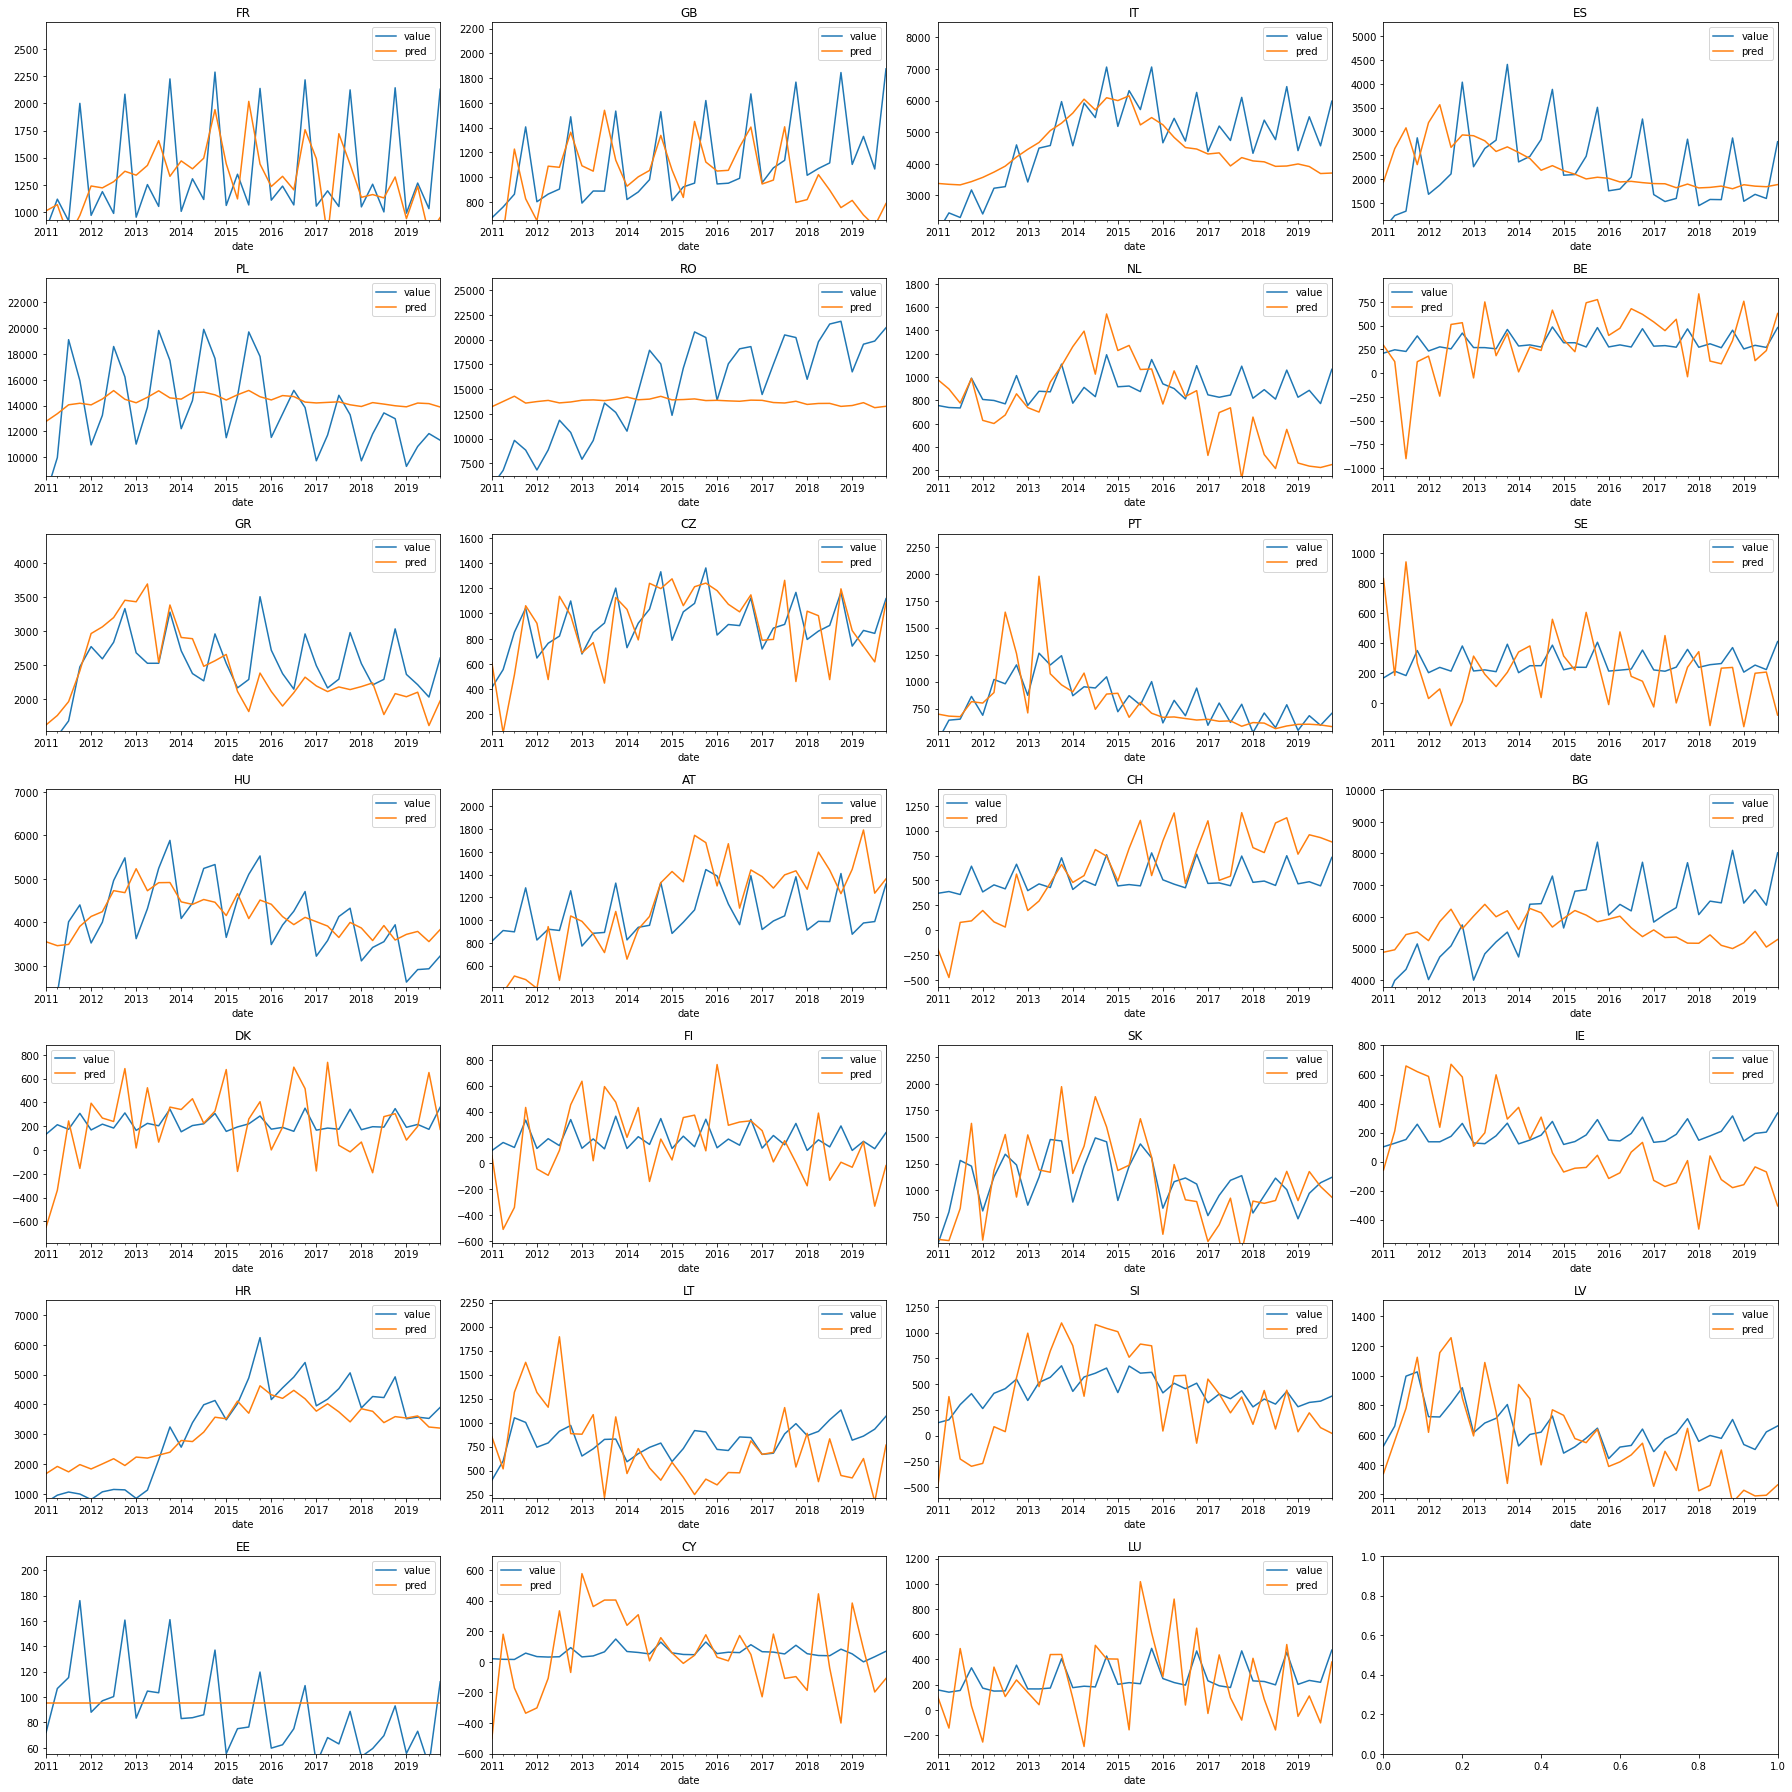

In [23]:
features = dummy_cols + ["19_1", "19_2", "19_3", "19_4"]

reg = linear_model.LinearRegression(fit_intercept=False)

# reg = ensemble.GradientBoostingRegressor()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)

display(pd.Series(reg.coef_, index=features))

fig, axs = plot_prediction(reg, x[features])



### kw 19 + ar(4)

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    0.013      0.006                    -0.641                               -758.698               0.924 
1    0.008      0.005                    -0.401                               -474.454               0.982 
2    0.006      0.006                    -0.229                               -608.334               0.978 
3    0.006      0.005                    -0.258                               -470.052               0.989 
4    0.006      0.005                    -0.225                               -690.314               0.972

Mean CV score:


fit_time                                     0.008
score_time                                   0.005
test_neg_mean_absolute_percentage_error     -0.351
test_neg_root_mean_squared_error          -600.370
test_r2                                      0.969
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.579e+15
neg_root_mean_squared_error          -4.372e+02
r2                                    9.893e-01
dtype: float64

AT      -510.852
BE      -428.206
BG       600.767
CH      -616.177
CY      -145.997
CZ      -371.743
DK      -473.740
EE        13.295
ES       262.423
FI      -343.667
FR      -371.716
GB      -489.376
GR        27.998
HR       367.809
HU       330.407
IE      -367.953
IT       515.950
LT      -181.150
LU      -211.897
LV      -215.465
NL      -546.454
PL      1983.665
PT        31.748
RO      3013.319
SE      -383.434
SI      -213.895
SK      -337.637
ar_1       0.194
ar_2      -0.141
ar_3       0.056
ar_4       0.719
19_1      14.283
19_2       5.927
19_3      -3.762
19_4      -3.144
dtype: float64

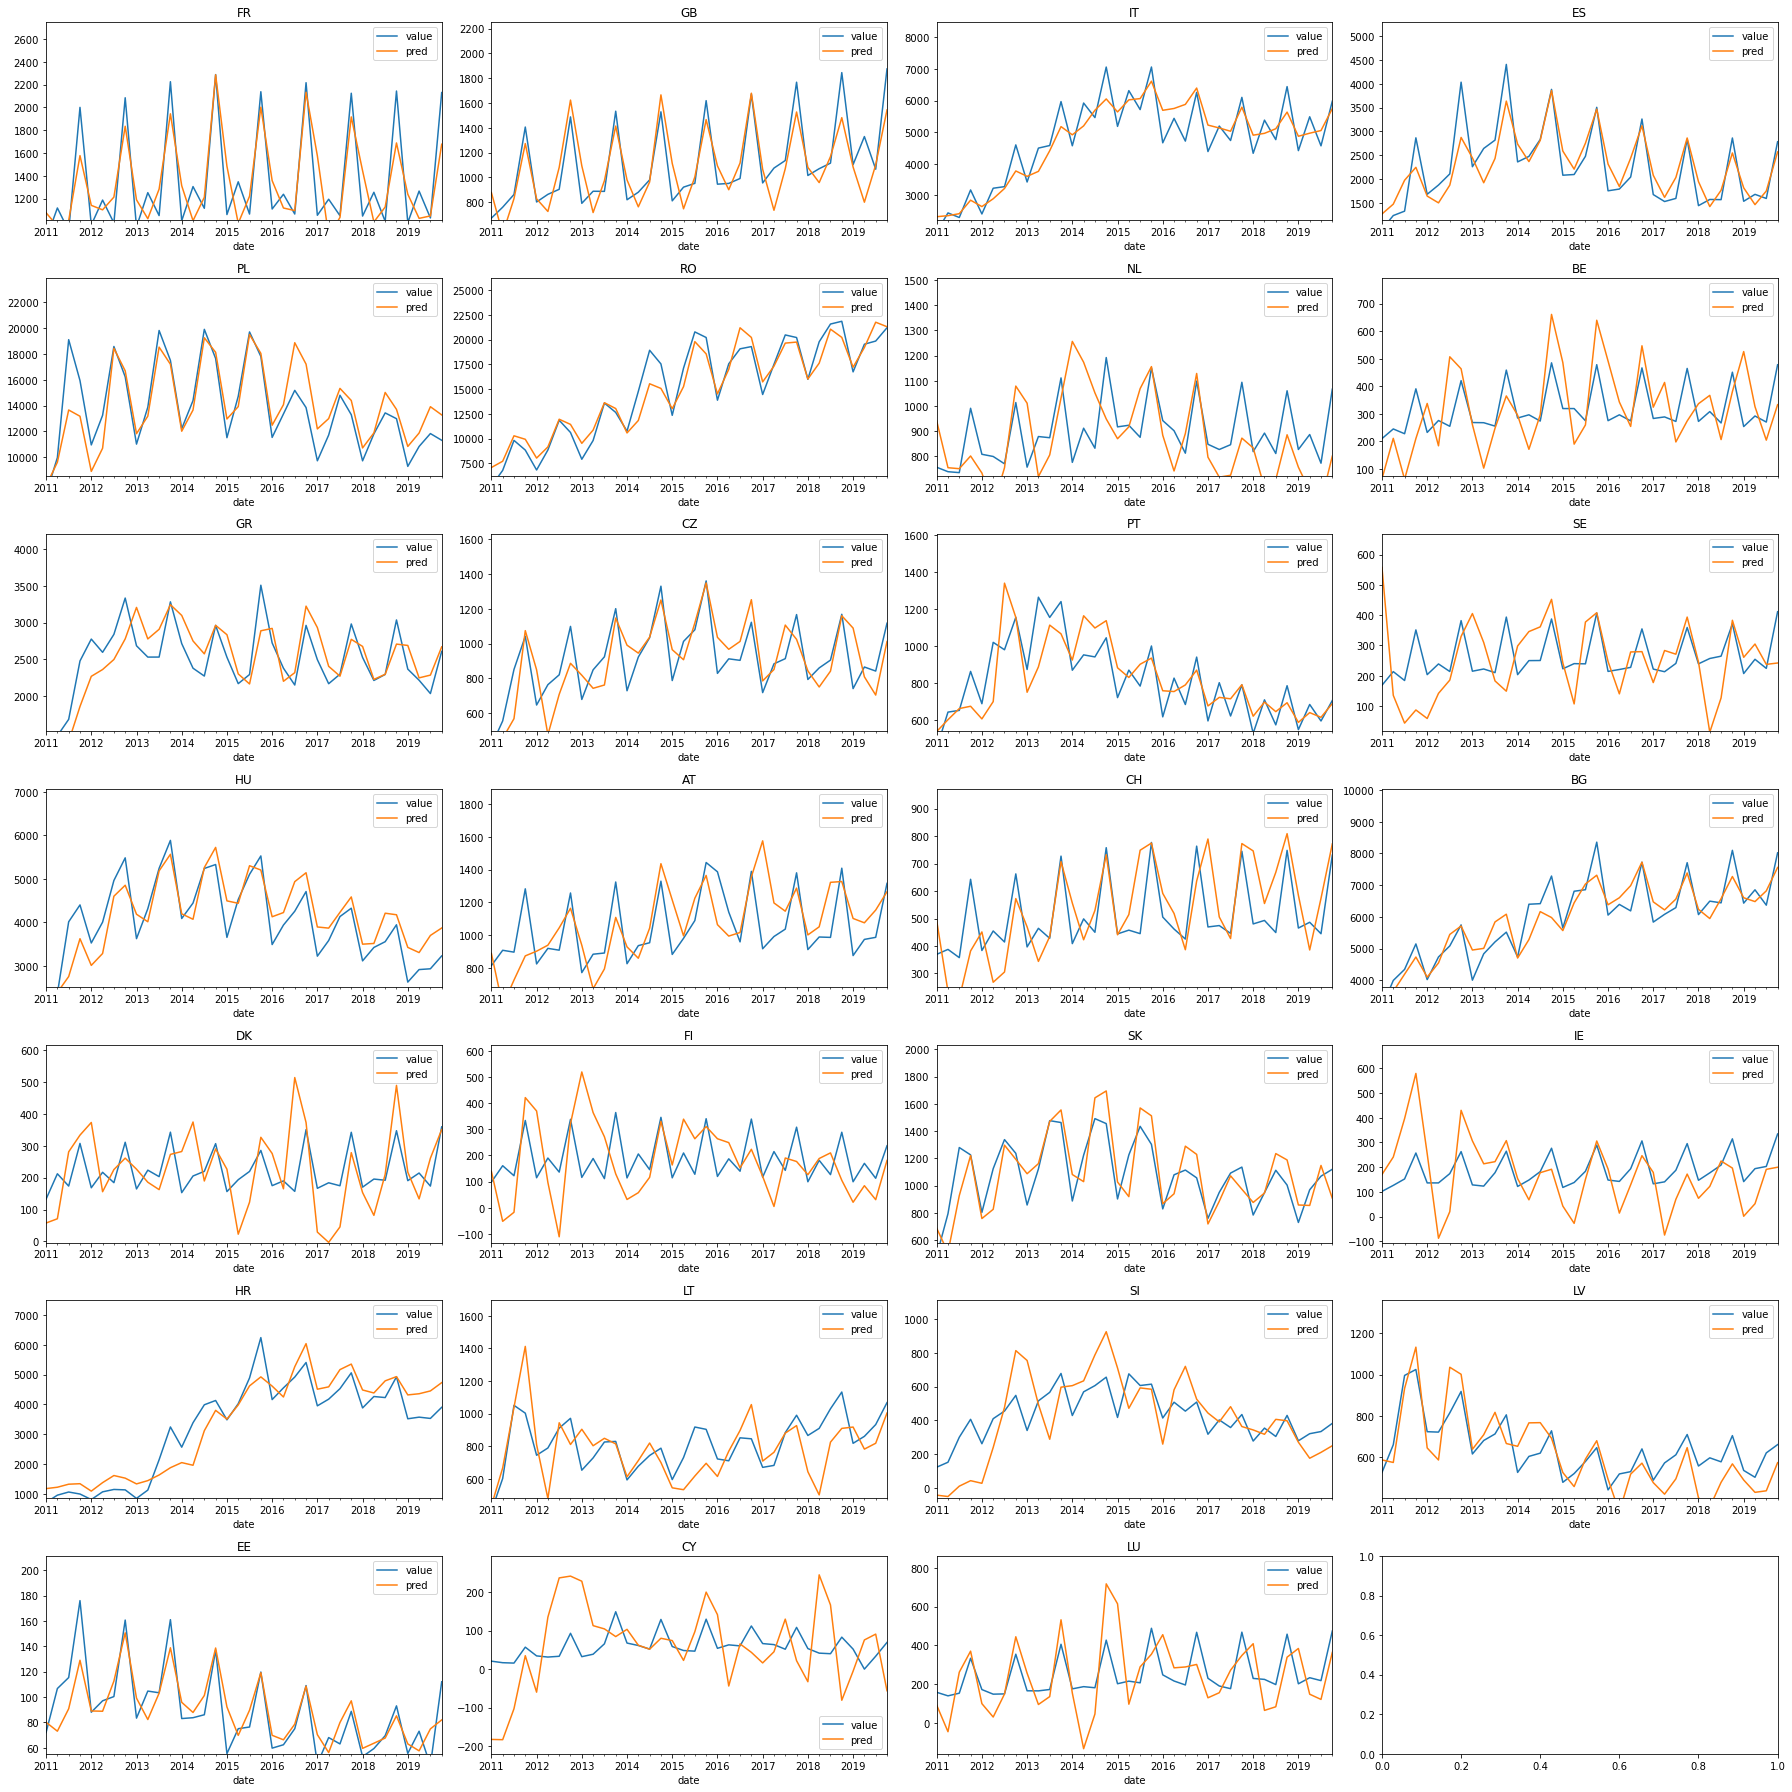

In [25]:
features = dummy_cols + ["ar_1", "ar_2", "ar_3", "ar_4", "19_1", "19_2", "19_3", "19_4"]

reg = linear_model.LinearRegression(fit_intercept=False)

# reg = ensemble.GradientBoostingRegressor()

reg.fit(x_train[features], y_train)

cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)

display(pd.Series(reg.coef_, index=features))

fig, axs = plot_prediction(reg, x[features])



### all keywords, season dummies, random forest

mean_fit_time  std_fit_time  mean_score_time  std_score_time  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0      3.552          0.259          0.012            0.002          -949.471           -723.147           -589.323           -907.394           -656.155          -765.098          140.547            1

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    4.139      0.013                    -1.792                               -908.731               0.891 
1    3.738      0.013                    -0.384                               -670.210               0.965 
2    3.527      0.013                    -0.181                               -645.988               0.975 
3    3.702      0.014                    -1.112                               -937.224               0.956 
4    3.984      0.013                    -0.391                               -636.009               0.976

Mean CV score:


fit_time                                     3.818
score_time                                   0.013
test_neg_mean_absolute_percentage_error     -0.772
test_neg_root_mean_squared_error          -759.632
test_r2                                      0.953
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -2.274e+15
neg_root_mean_squared_error          -8.670e+02
r2                                    9.577e-01
dtype: float64

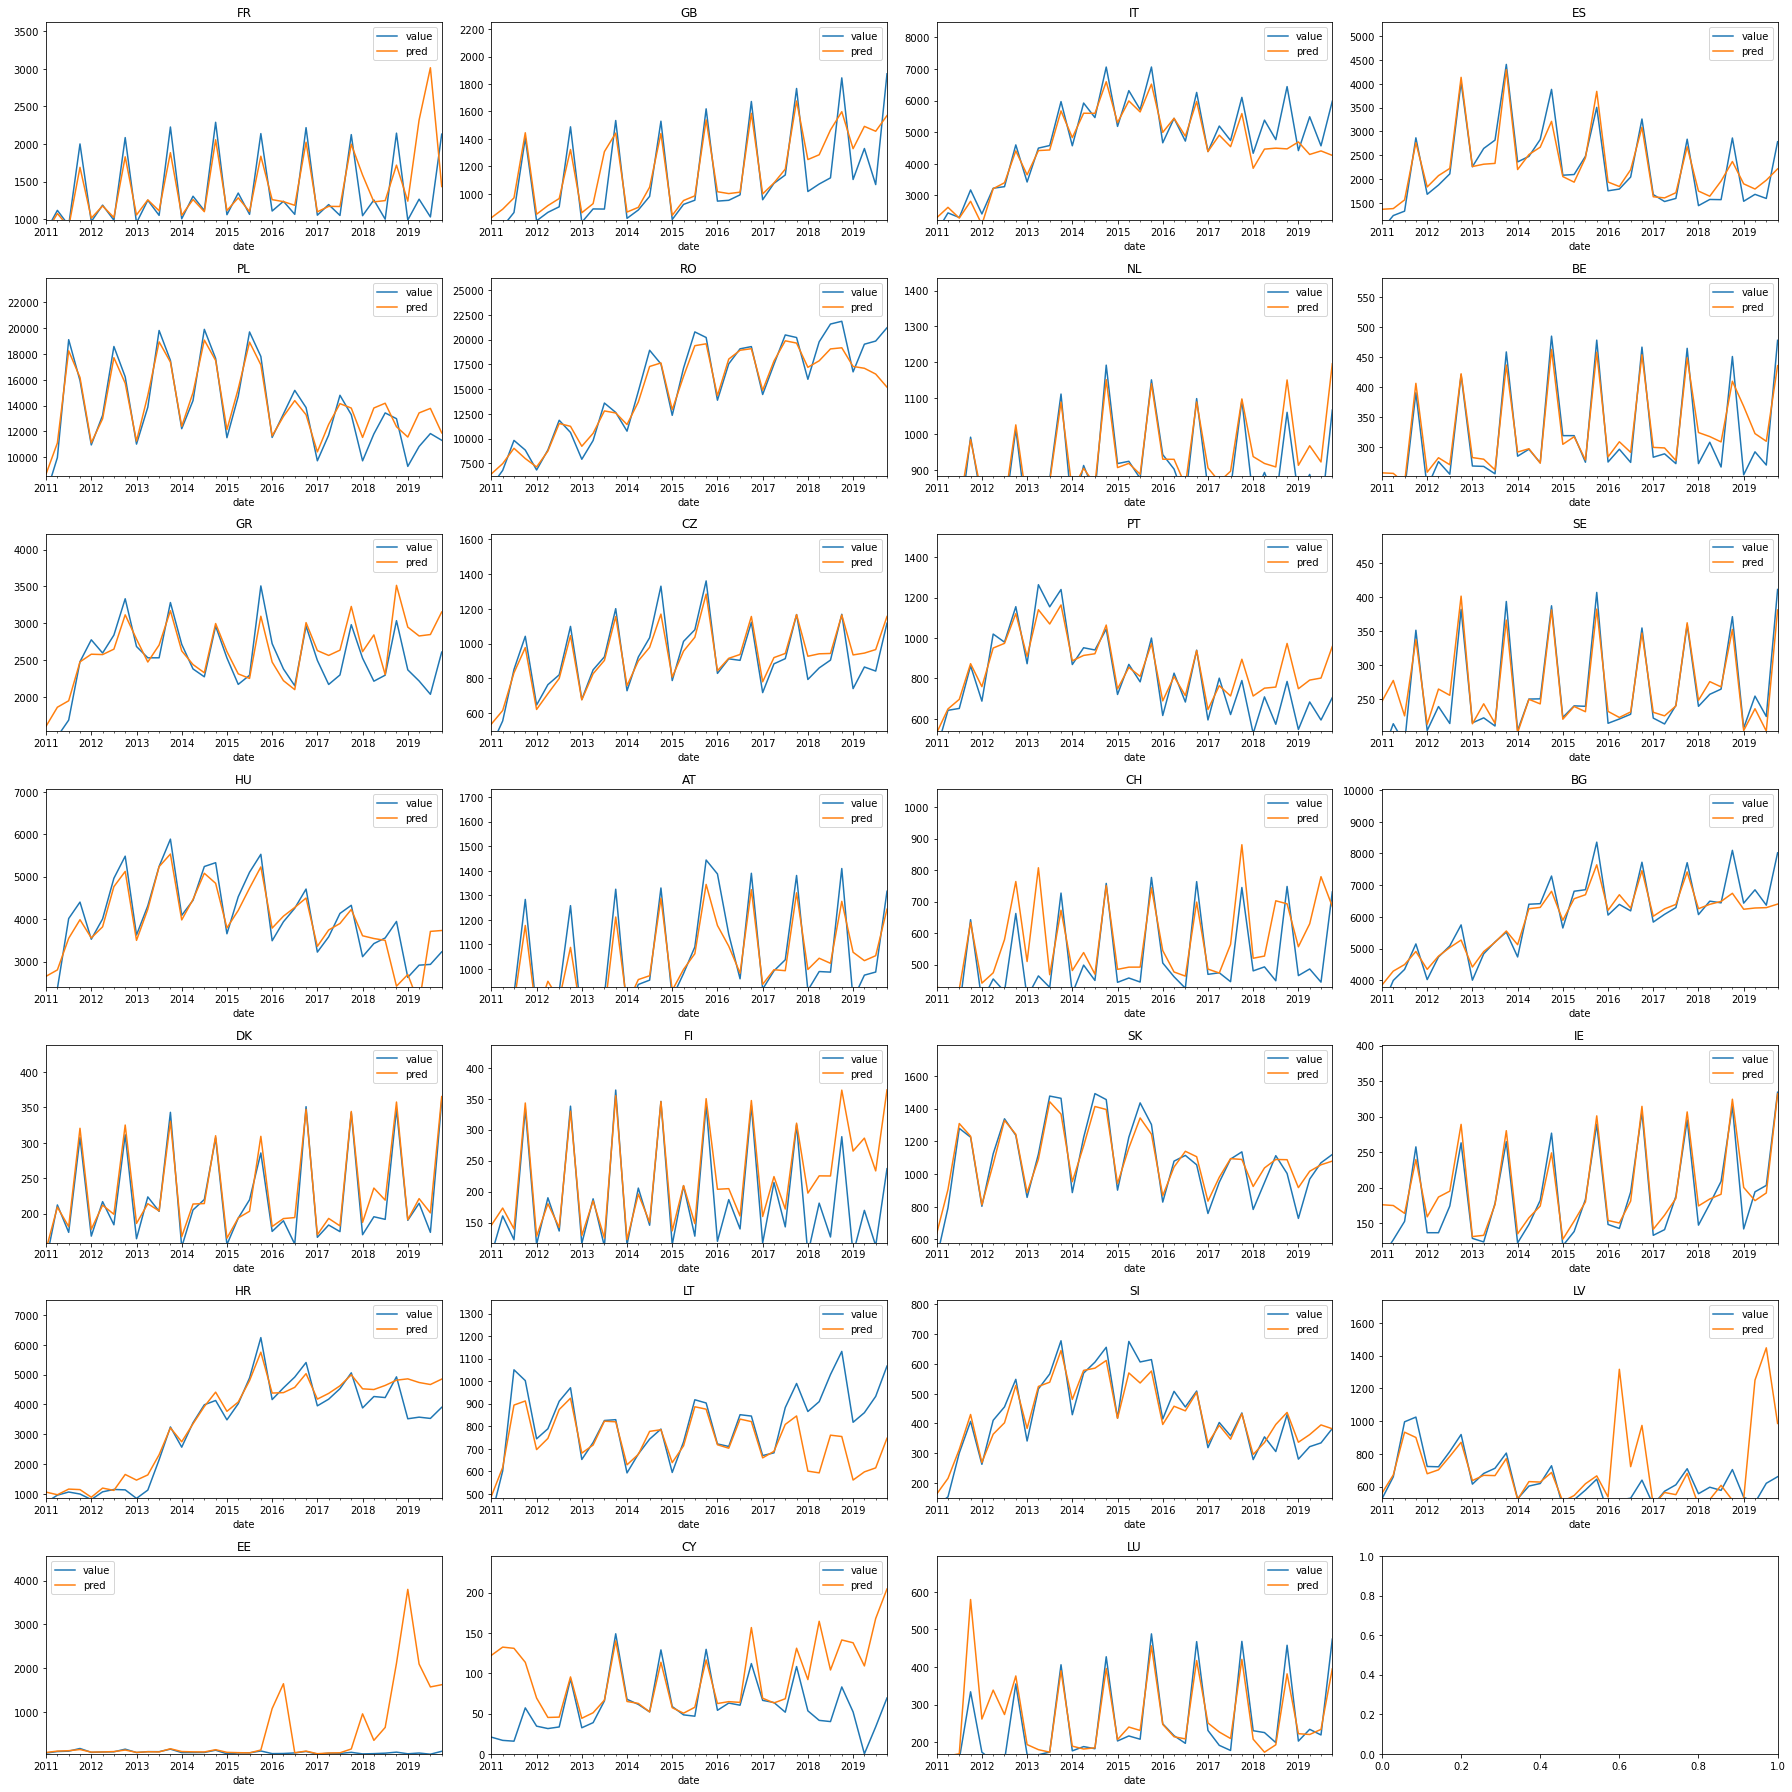

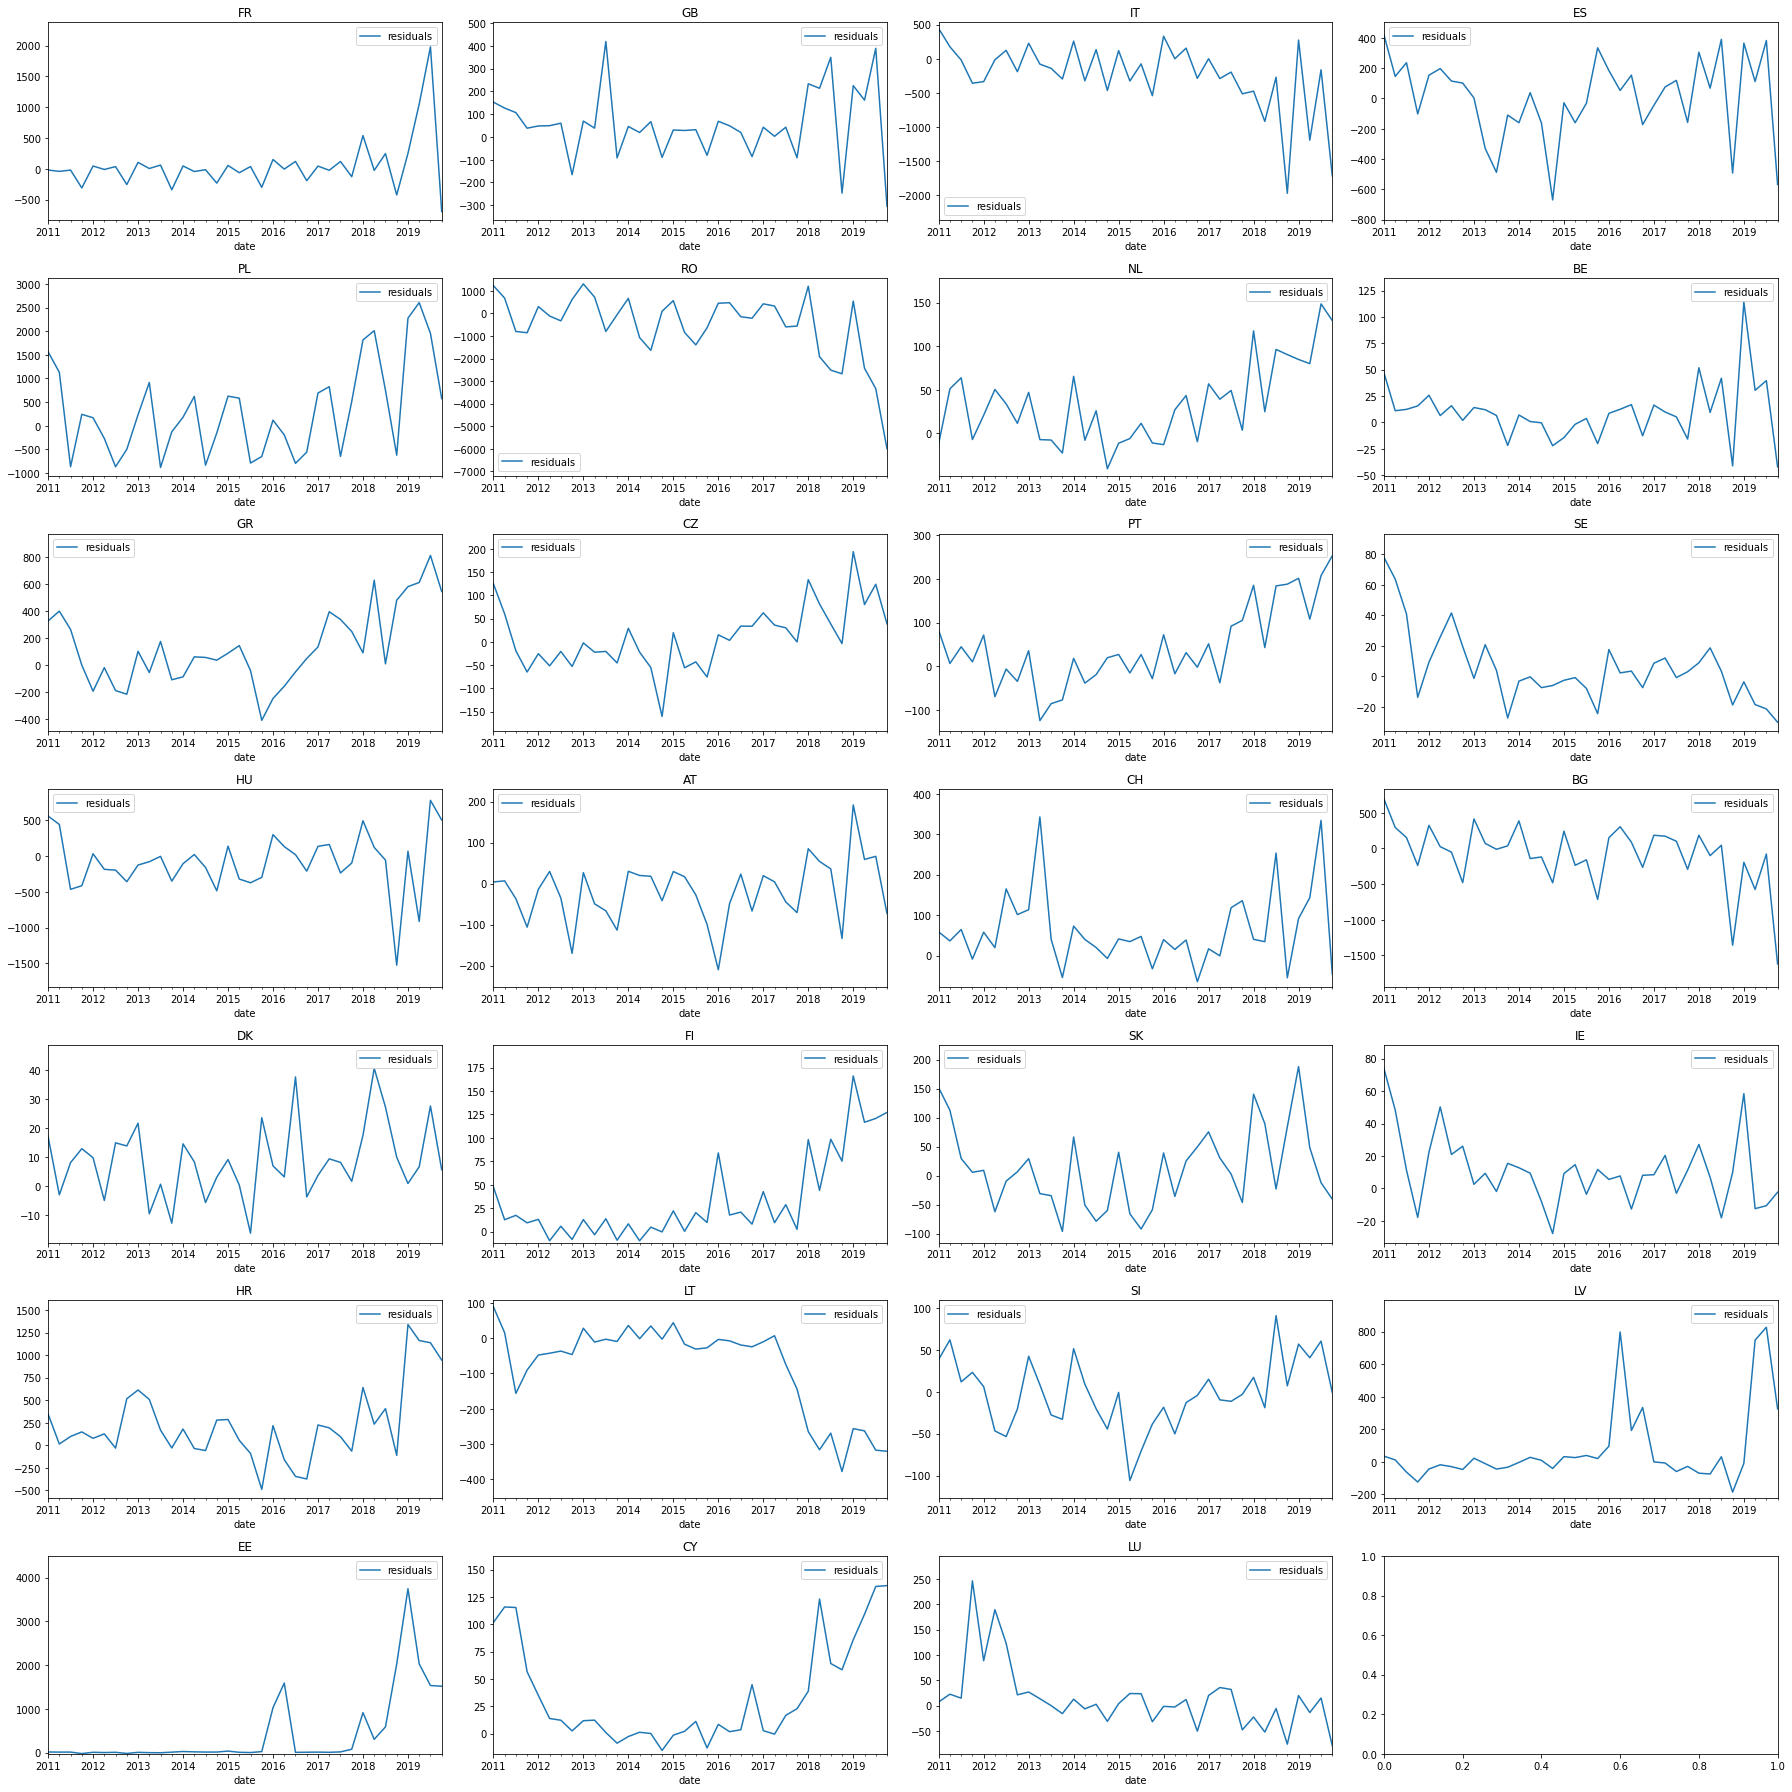

In [27]:
features = (
    dummy_cols + dummy_cols_month
    + [k + "_1" for k in keyword_ids]
    + [k + "_2" for k in keyword_ids]
    + [k + "_3" for k in keyword_ids]
    + [k + "_4" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = ensemble.RandomForestRegressor()
# reg_unfitted = linear_model.LinearRegression()
params = {}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

# lasso_coefs = reg.coef_
# print("ElasticNet Coefficients:")
# print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lb

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_mlpregressor__alpha  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0      8.105          0.301          0.007          9.708e-04                0.0               -816.061           -602.249           -679.958           -709.472           -554.089          -672.366          90.541             3       
1      7.853          1.171          0.006          4.567e-04              0.001               -787.595           -608.986           -682.491           -712.961           -568.541          -672.115          77.233             2       
2      7.753          0.423          0.007          9.646e-04               0.01               -773.999           -586.214           -681.615           -714.686           -597.611          -670.825          70.999             1

/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/stei509/anaconda3/envs/eumf/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lb

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    7.255      0.007                    -0.334                               -810.705               0.913 
1    7.593      0.010                    -0.395                               -588.087               0.973 
2    7.306      0.009                    -0.163                               -688.853               0.972 
3    7.192      0.006                    -0.198                               -713.666               0.974 
4    7.308      0.008                    -0.257                               -544.383               0.983

Mean CV score:


fit_time                                     7.331
score_time                                   0.008
test_neg_mean_absolute_percentage_error     -0.269
test_neg_root_mean_squared_error          -669.139
test_r2                                      0.963
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.045e+15
neg_root_mean_squared_error          -5.844e+02
r2                                    9.808e-01
dtype: float64

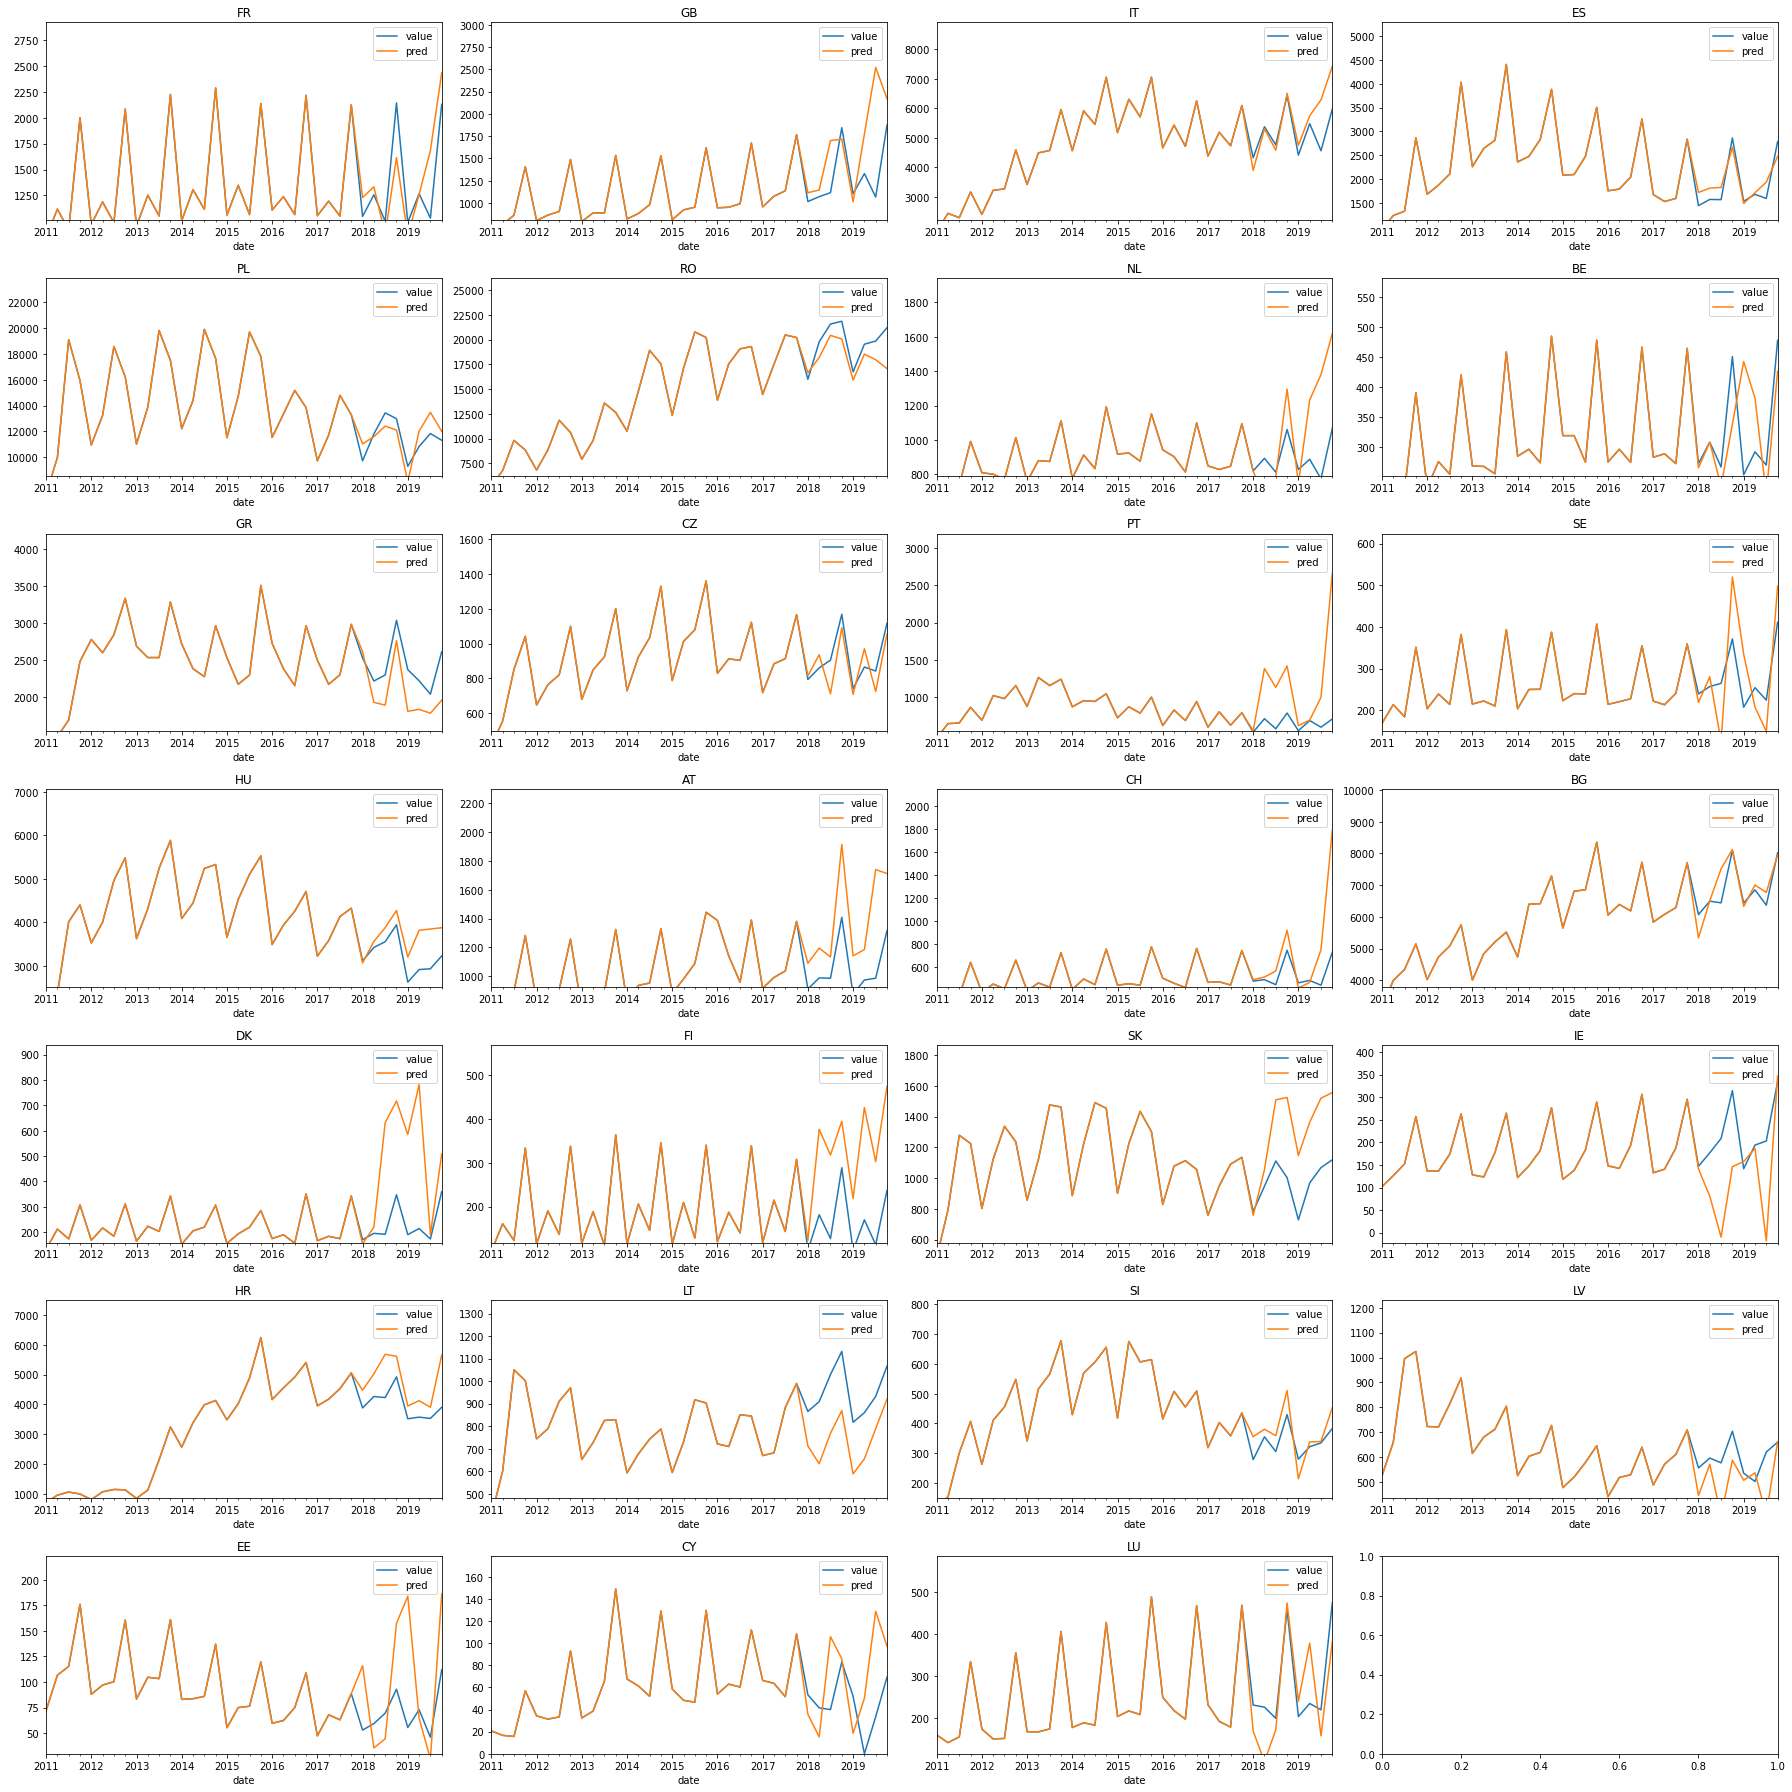

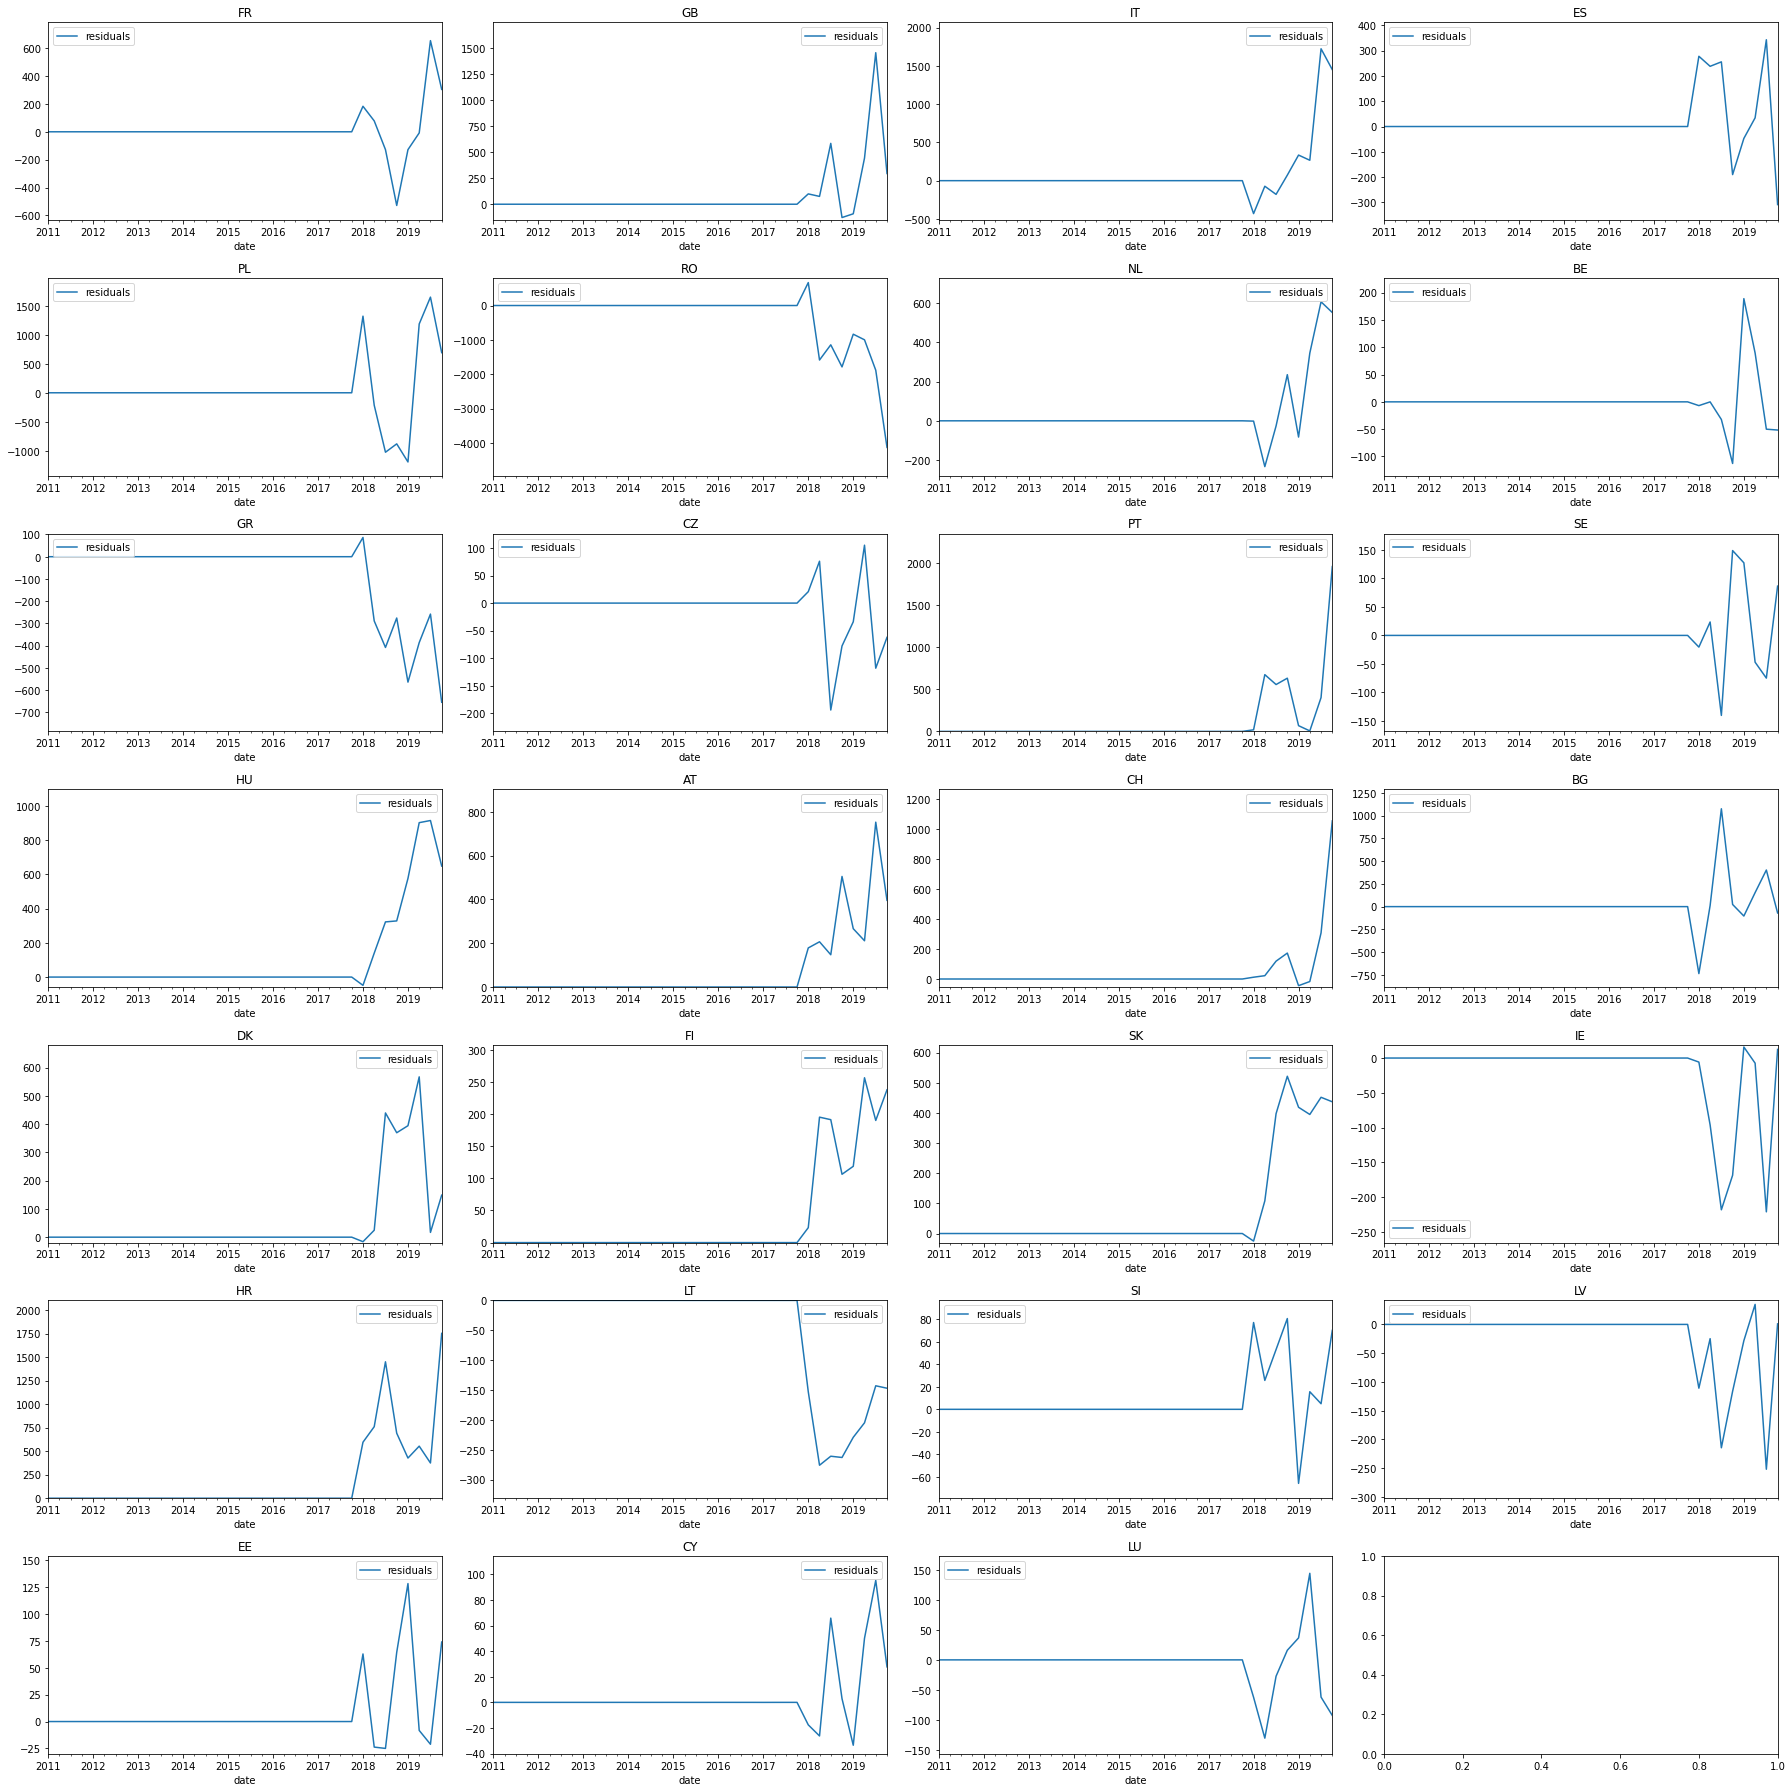

In [39]:
features = (
    dummy_cols
    + dummy_cols_month
    + [k + "_1" for k in keyword_ids]
    + [k + "_2" for k in keyword_ids]
    + [k + "_3" for k in keyword_ids]
    + [k + "_4" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = neural_network.MLPRegressor(
    hidden_layer_sizes=(100,), max_iter=1000, solver="lbfgs"
)
# reg_unfitted = linear_model.LinearRegression()
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(), reg_unfitted)
params = {"mlpregressor__alpha": [0.0001, 0.001, 0.01]}
tuner = model_selection.GridSearchCV(
    pipe, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

# lasso_coefs = reg.coef_
# print("ElasticNet Coefficients:")
# print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])



### all keywords + ar(4), random forest

mean_fit_time  std_fit_time  mean_score_time  std_score_time  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0      1.424           0.1           0.003          9.229e-04         -0.27              -0.173             -0.217             -0.134             -0.115            -0.182            0.057             1

fit_time  score_time  test_neg_mean_absolute_percentage_error  test_neg_root_mean_squared_error  test_r2
0    2.057      0.004                  -5.354e+12                              -0.271                0.223 
1    1.819      0.004                  -2.131e+00                              -0.171                0.349 
2    1.969      0.004                  -3.128e+00                              -0.221                0.532 
3    1.671      0.003                  -5.425e+00                              -0.132               -0.157 
4    1.586      0.004                  -2.366e+00                              -0.115               -0.351

Mean CV score:


fit_time                                   1.820e+00
score_time                                 3.914e-03
test_neg_mean_absolute_percentage_error   -1.071e+12
test_neg_root_mean_squared_error          -1.820e-01
test_r2                                    1.192e-01
dtype: float64

OOS score:


neg_mean_absolute_percentage_error   -1.256e+12
neg_root_mean_squared_error          -9.719e-02
r2                                    2.012e-02
dtype: float64

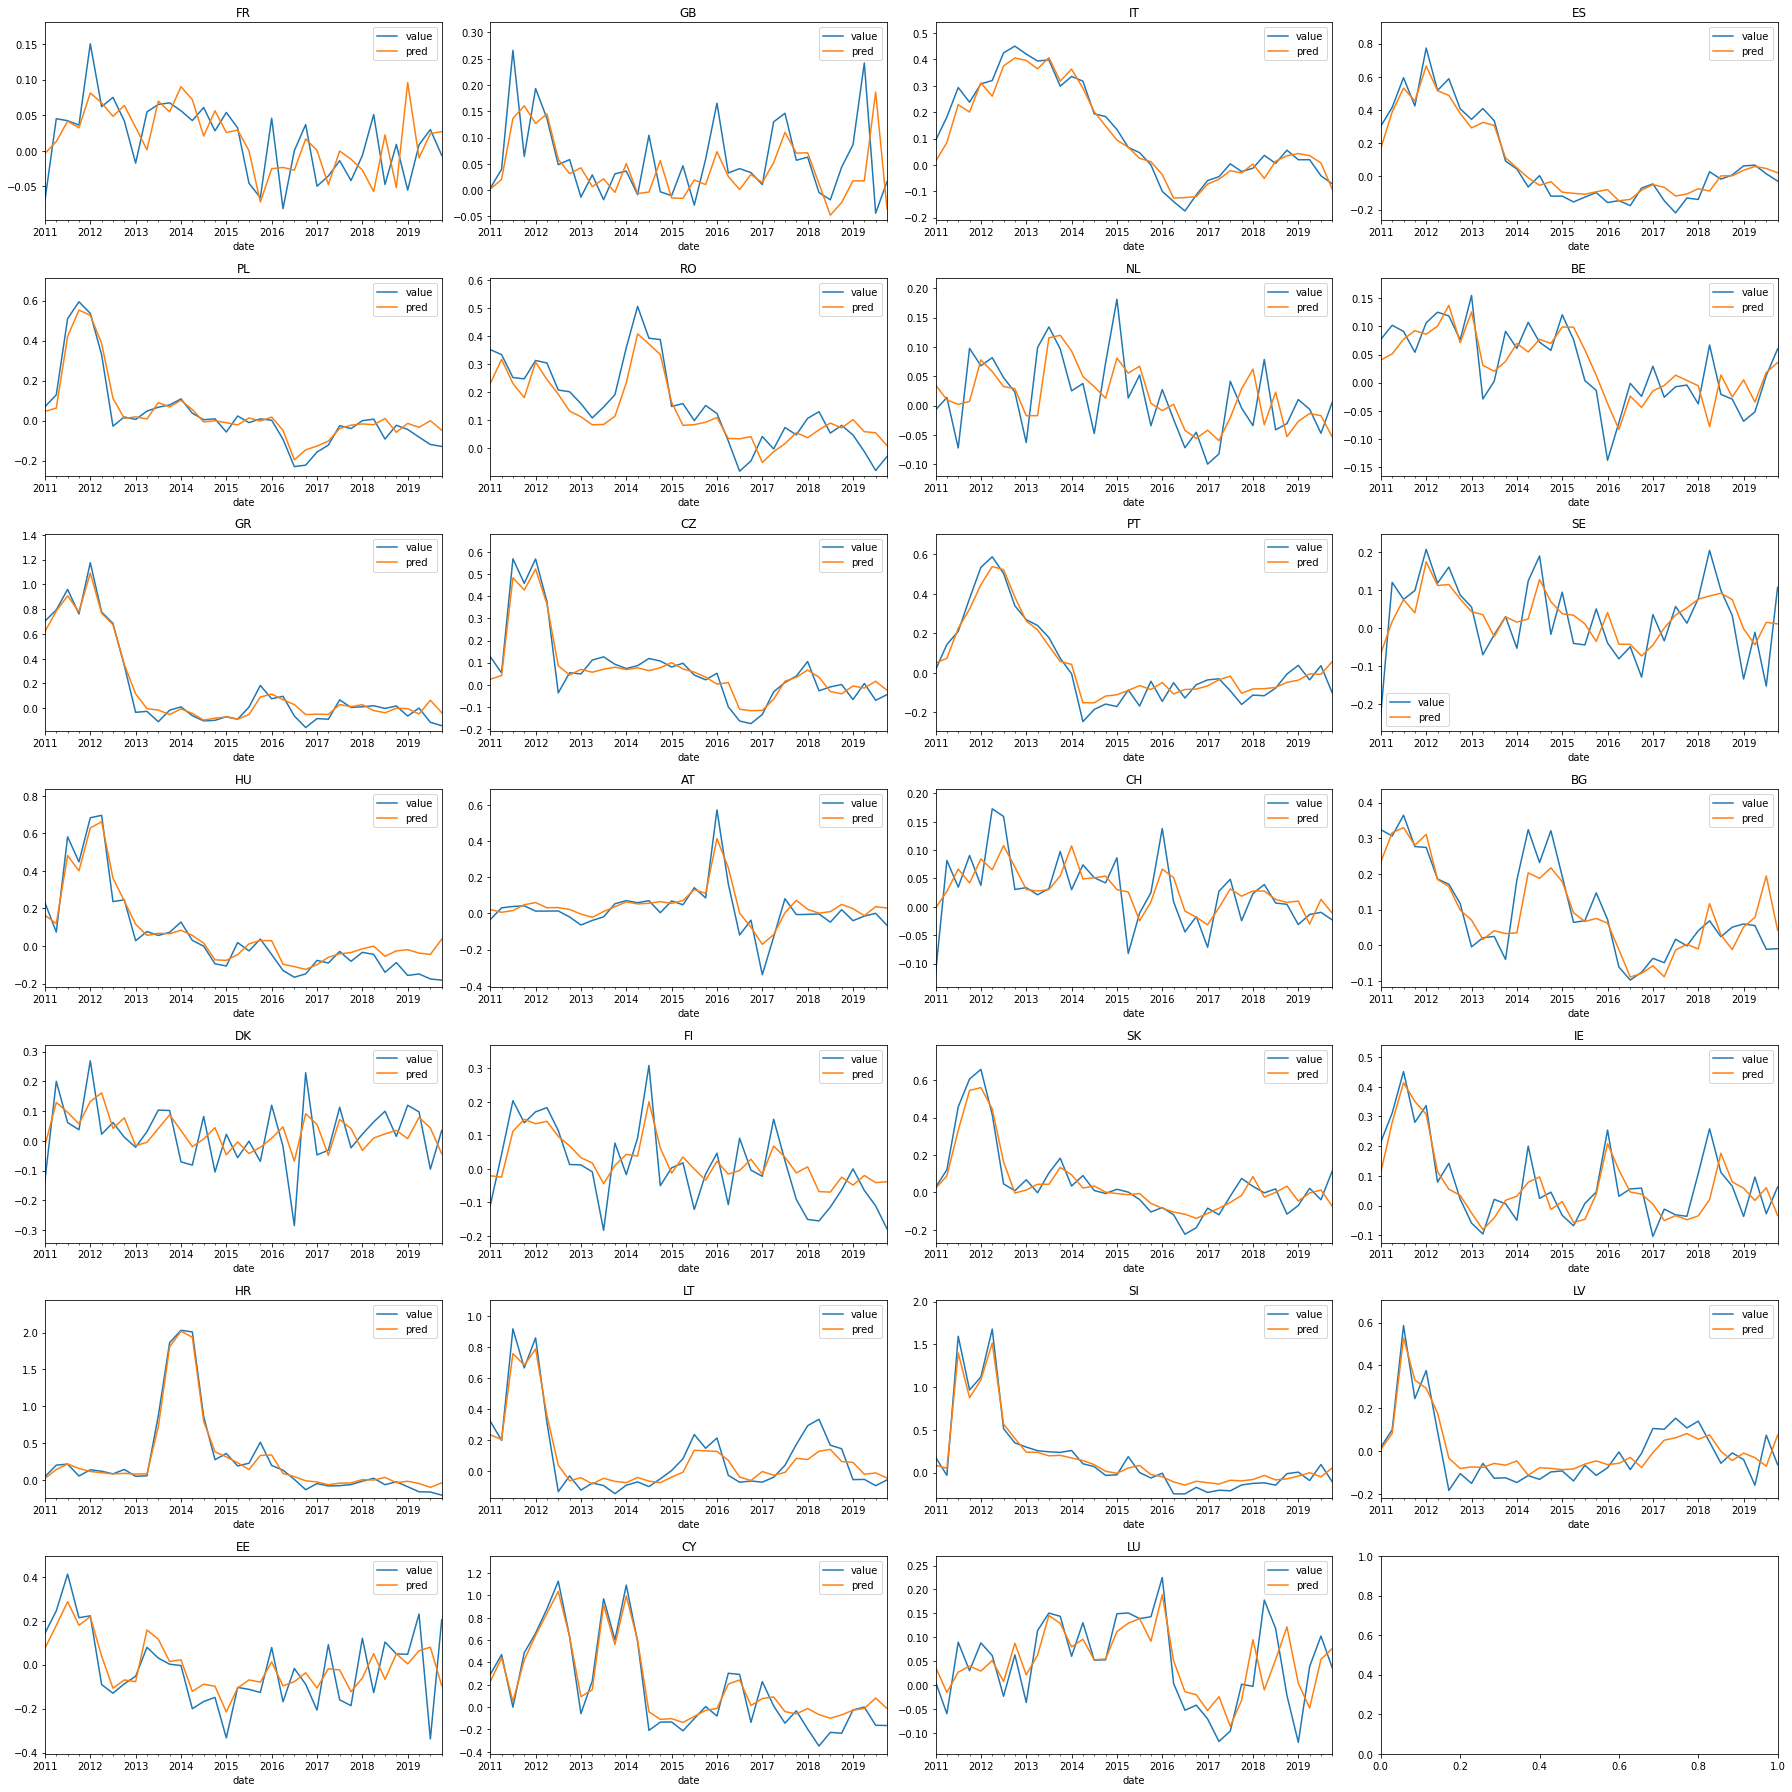

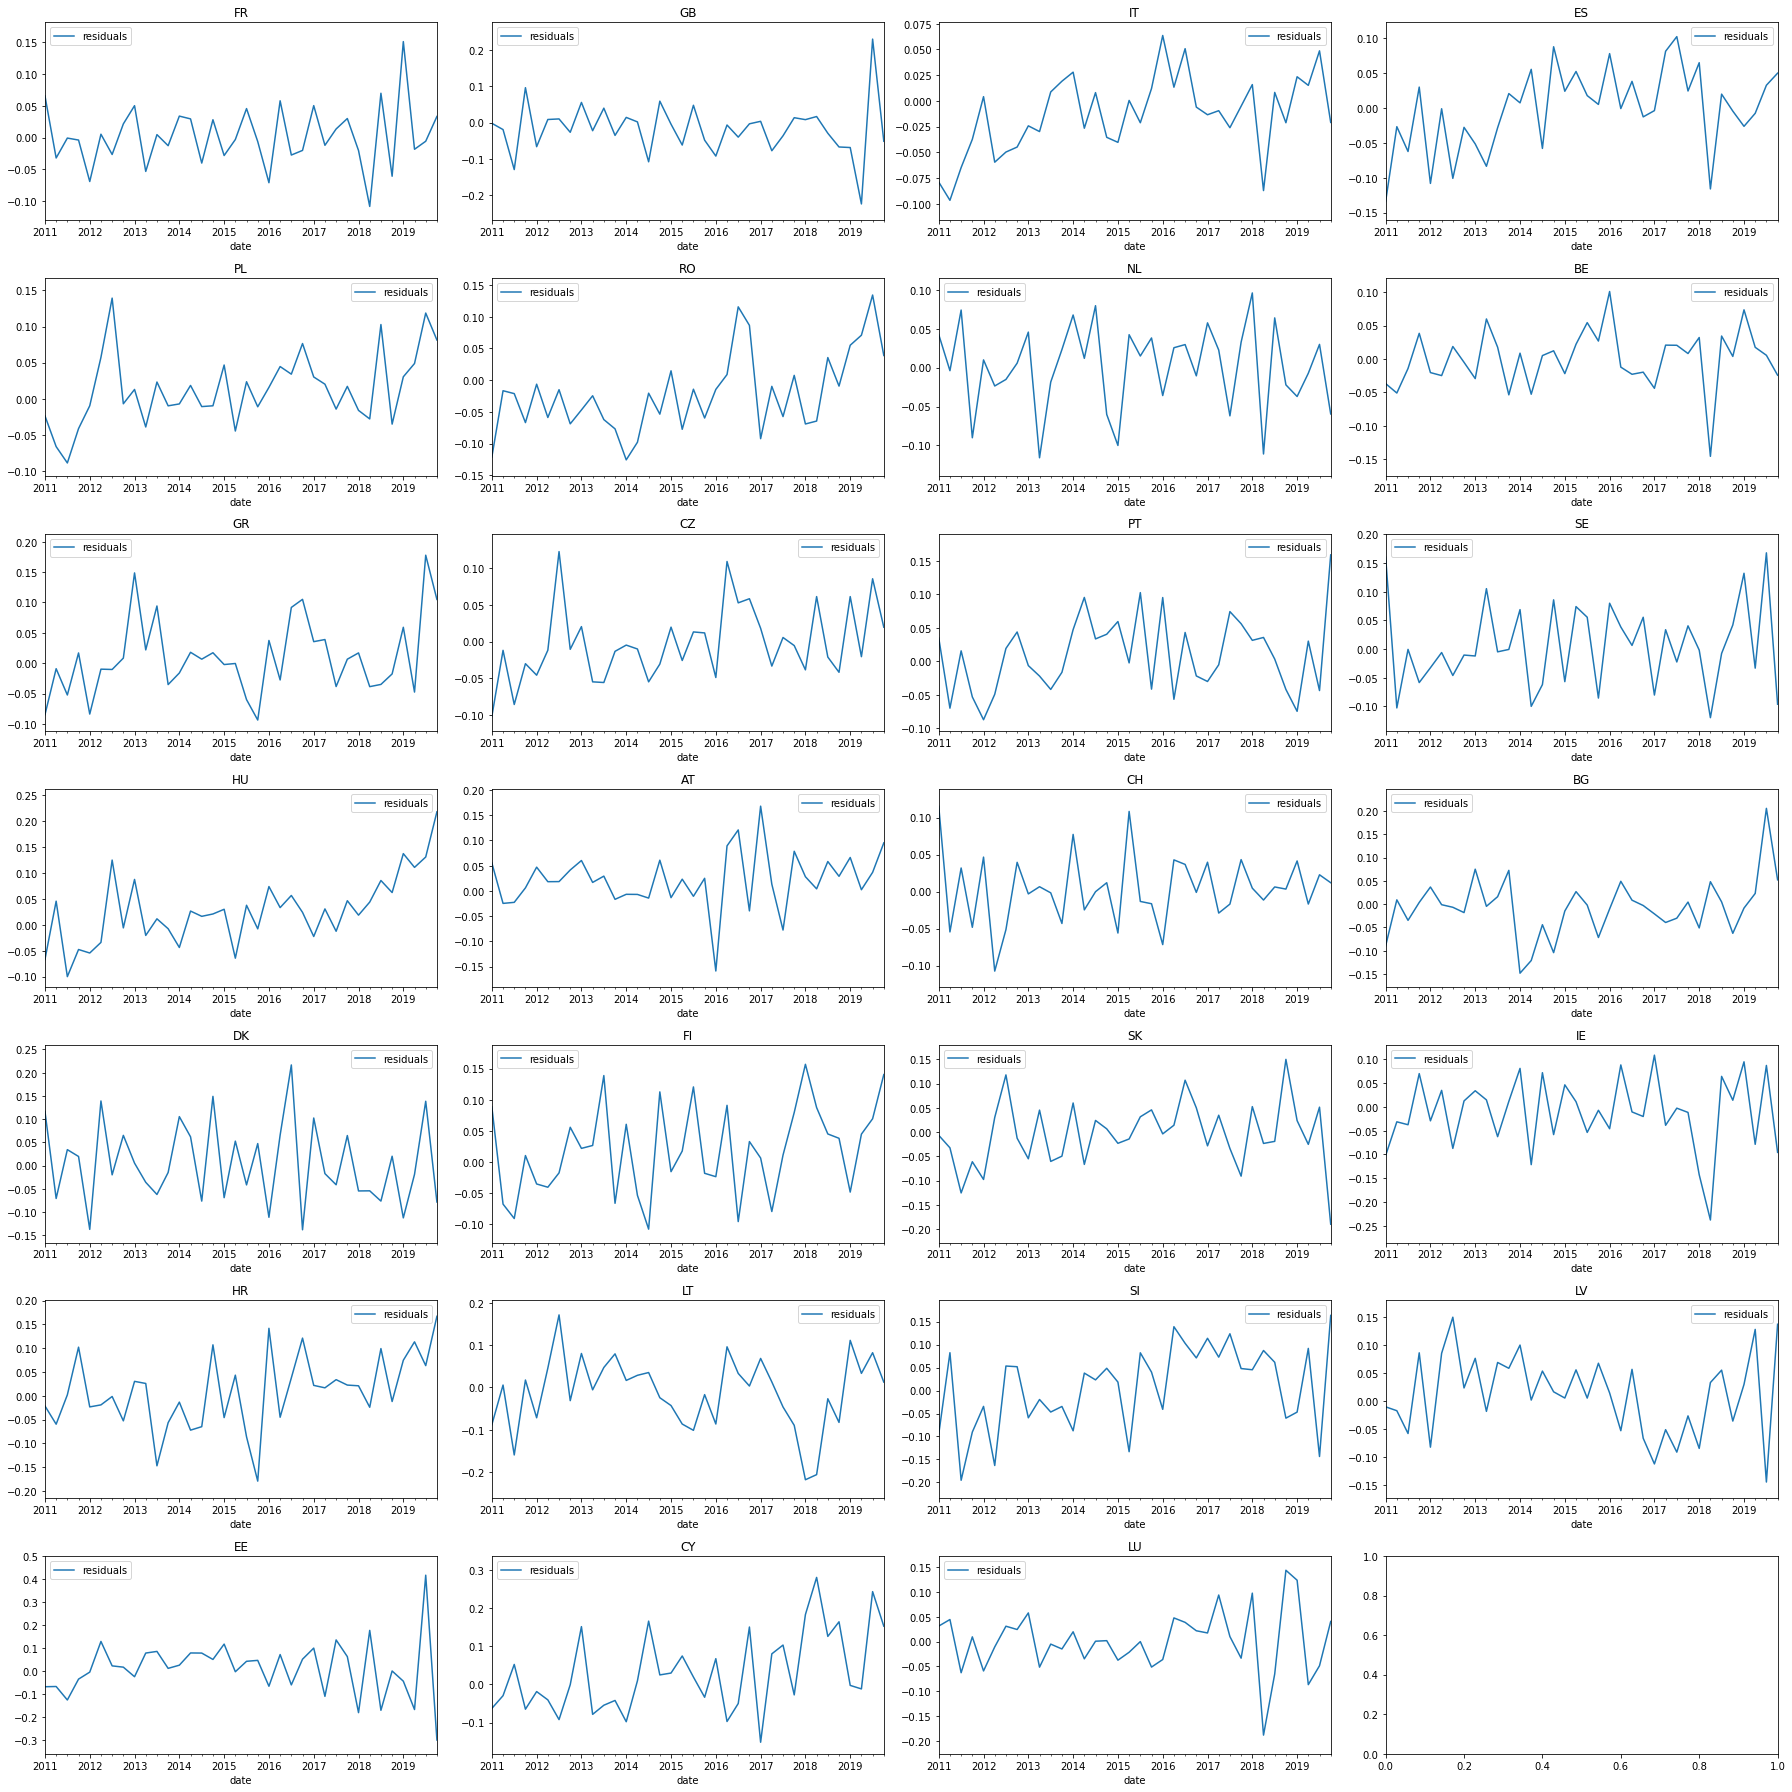

In [72]:
features = (
    ["ar_1", "ar_2", "ar_3", "ar_4"] +
    [k + "_1" for k in keyword_ids]
    + [k + "_2" for k in keyword_ids]
    + [k + "_3" for k in keyword_ids]
    + [k + "_4" for k in keyword_ids]
)

# reg = linear_model.Lasso(positive=True, normalize=True, alpha=10.0)
reg_unfitted = ensemble.GradientBoostingRegressor()
# reg_unfitted = linear_model.LinearRegression()
params = {}
tuner = model_selection.GridSearchCV(
    reg_unfitted, params, scoring="neg_root_mean_squared_error"
)

tuner.fit(x_train[features], y_train)

display(pd.DataFrame(tuner.cv_results_).drop(columns="params"))
reg = tuner.best_estimator_

# lasso_coefs = reg.coef_
# print("ElasticNet Coefficients:")
# print(pd.Series(lasso_coefs, features).sort_values(ascending=False).to_string())


cv_score = score_cv(reg, x_train[features], y_train)
display(cv_score)
print("Mean CV score:")
display(cv_score.mean())
print("OOS score:")
test_score = score_test(reg, x_test[features], y_test)
display(test_score)
fig, axs = plot_prediction(reg, x[features])
fig, axs = plot_residuals(reg, x[features])

